In [4]:
%%javascript

IPython.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : "run cell and keep focus", //This is optional
    handler : function (event) {
        IPython.notebook.execute_cell();
        IPython.notebook.edit_mode();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [5]:
# 1. train a baseline for imagenet.
# 2. given this, train adapter networks for each of the other networks.
from funs import *

In [39]:
#origModelParams = countModelParameters(model) # 6103480
#origFCParams = countModelParameters(model.fc) # 257000
#PPP = origModelParams-origFCParams # 5846480
origModelParams =   6103480
origFCParams = 257000
PPP =5846480

In [6]:
from os.path import expanduser
homeDir = expanduser('~')
# yellowfin :-)
sys.path.append(os.path.join(homeDir, 'YellowFin_Pytorch/tuner_utils/'))
from yellowfin import YFOptimizer
from tensorboard_logger import configure, log_value, Logger

import hickle as pickle
import jsonima
baseDataDir = os.path.join(homeDir, 'decathlon/decathlon-1.0-data/')
all_datasets = pickle.load(
    open(os.path.join(homeDir, 'decathlon/database_stats')))

# modelsBaseDir = '/home/amir/models/decathlon/' # this was for ResNet18.
# different initialization
modelsBaseDir = os.path.join(homeDir, 'models/decathlon_wide28/')
base_lr = .1

# make it compatible with the dataloader function.
for k, d in all_datasets.iteritems():
    s = all_datasets[k]['stats']
    s = (tuple([float(q) for q in s[0]]), tuple([float(q) for q in s[1]]))
    all_datasets[k]['stats'] = s
# update the datasets-extra parameter.
# do training/testing
torch.backends.cudnn.benchmark = True
for k, v in all_datasets.iteritems():
    all_datasets[k]['nClasses'] = len(
        glob.glob(os.path.join(baseDataDir, v['train'] + '/*')))
extraDataPath = os.path.join(homeDir, 'decathlon/database_stats_extra')
B = os.path.join(homeDir, 'decathlon/decathlon-1.0')
import cPickle as pickle
if True:
    if not os.path.isfile(extraDataPath):
        # make sure that there's a 1-1 transformation between the subdirectories and categories
        from collections import OrderedDict

        dataset_names = all_datasets.keys()

        for n in sorted(dataset_names):
            print n
            anno_file = os.path.join(os.path.join(
                homeDir, 'decathlon/decathlon-1.0/annotations/' + n + '_train.json'))
            a = open(anno_file)
            D = json.load(a)
            dir_to_cat = {}
            cat_to_dir = {}

            for img, cat in zip(D['images'], D['annotations']):
                s = img['file_name'].split('/')
                curDir = s[-2]
                curCat = cat['category_id']
                if curDir in dir_to_cat:
                    assert dir_to_cat[curDir] == curCat
                    assert cat_to_dir[curCat] == curDir
                else:
                    dir_to_cat[curDir] = curCat
                    cat_to_dir[curCat] = curDir

                assert(img['id'] == cat['image_id'])
            all_datasets[n]['dir_to_cat'] = dir_to_cat
            all_datasets[n]['cat_to_dir'] = cat_to_dir
            all_datasets[n]['file_name_to_id'] = D['images']

        for n in sorted(dataset_names):
            print n
            anno_file = os.path.join(os.path.join(
                homeDir, 'decathlon/decathlon-1.0/annotations/' + n + '_val.json'))
            a = open(anno_file)
            D = json.load(a)
            all_datasets[n]['file_name_to_id_val'] = D['images']
            anno_file = os.path.join(os.path.join(
                homeDir, 'decathlon/decathlon-1.0/annotations/' + n + '_test_stripped.json'))
            a = open(anno_file)
            D = json.load(a)
            all_datasets[n]['file_name_to_id_test'] = D['images']
        pickle.dump(all_datasets, open(extraDataPath, 'w'), protocol=2)
    all_datasets = pickle.load(open(extraDataPath))
else:
    print 'CURRENTLY SKIPPING LOADING DATA FOR FINAL EVALUATION'


def makeLoaders(train_dir, test_dir, stats, augment_flip=True, augment_crop=True,
                crop_fill=0, train_batch_size=128, toNormalize=True):
    # remove mean and divide by std (computed stats is variance, hence sqrt)
    kwargs = {'num_workers': 2, 'pin_memory': False}
    print 'normalize', toNormalize
    normalize = transforms.Normalize(
        np.asarray(stats[0]), np.asarray(stats[1]))
    # random crop for jittering at train time.
    transform_list = []
    scaling_factor = 64
    if augment_crop:
        # RandomCrop(scaling_factor,0,fill = 0))
        transform_list.append(transforms.RandomCrop(scaling_factor, 0))
    if augment_flip:
        transform_list.append(transforms.RandomHorizontalFlip())

    transform_list.append(transforms.ToTensor())
    if toNormalize:
        transform_list.append(normalize)
    transform_train = transforms.Compose(transform_list)

    db_train = DataLoader(dataset=datasets.ImageFolder(root=train_dir, transform=transform_train),
                          batch_size=train_batch_size, shuffle=True, **kwargs)
    transform_test_list = [transforms.CenterCrop(64), transforms.ToTensor()]
    if toNormalize:
        transform_test_list.append(normalize)

    transform_test = transforms.Compose(transform_test_list)

    db_test = DataLoader(dataset=datasets.ImageFolder(root=test_dir, transform=transform_test),
                         batch_size=64, shuffle=False)
    return db_train, db_test


def adjust_learning_rate(optimizer, epoch, base_lr, lr_drop_freq=100, gamma=0.1):
    """Sets the learning rate to the initial LR decayed by gamma every K epochs"""
    if (epoch + 1) % lr_drop_freq == 0:  # Note this works only for continuous mode (not stopping+loading)
        if type(optimizer) is YFOptimizer:
            optimizer.set_lr_factor(optimizer.get_lr_factor() * gamma)
        else:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * gamma
                
                
def adjust_learning_rate2(optimizer, epoch, base_lr, lr_drop_freq=100, gamma=0.1):
    """Sets the learning rate to the initial LR decayed by gamma every K epochs"""
    if epoch == 39:
        for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01
    elif epoch == 49:
        for param_group in optimizer.param_groups:
                param_group['lr'] = 0.001                

    # for param_group in optimizer.param_groups:
     #   param_group['lr'] = lr


def doTraining(name, model, optimizer='sgd', base_lr=.1, sfx='', batch_size=128, augment_flip=True, augment_crop=True,
               toNormalize=True,adjust_learning_rate=adjust_learning_rate,weight_decay=5e-4,epochs=150):
    trainDir = os.path.join(baseDataDir, all_datasets[name]['train'])
    testDir = os.path.join(baseDataDir, all_datasets[name]['val'])
    print 'normalize:', toNormalize
    train_loader, test_loader = makeLoaders(trainDir, testDir, all_datasets[name]['stats'], augment_flip=augment_flip,
                                            augment_crop=augment_crop, train_batch_size=batch_size, toNormalize=toNormalize)
    model.cuda()
    name += '_wide28'
    name += 'opt_{}_bs_{}_base_lr_{}_wd_{}_flp_{}_nrmlz_{}'.format(optimizer,batch_size,base_lr,weight_decay,augment_flip,toNormalize)
    modelDir = os.path.join(modelsBaseDir, name + sfx)
    adjust_learning_rate_fn = adjust_learning_rate
    logger = Logger('runs/' + name + sfx)
    params = [p for p in model.parameters() if p.requires_grad]
    if optimizer == 'sgd':
        print 'FOO\n\n\n'
        optimizer = optim.SGD(params=params, lr=base_lr,
                              momentum=0.9, weight_decay=weight_decay, nesterov=True)
    elif optimizer == 'yf':
        base_lr = .1
        optimizer = YFOptimizer(
            params, lr=base_lr, mu=0.0, weight_decay=weight_decay, clip_thresh=2.0, curv_win_width=20)
    else:
        optimizer = optim.Adam(params)
        adjust_learning_rate_fn = adjust_learning_rate
    print adjust_learning_rate_fn

    trainAndTest(model, optimizer, modelDir, epochs=epochs, train_loader=train_loader, model_save_freq=10,
                 test_loader=test_loader, adjust_learning_rate=adjust_learning_rate_fn,
                 base_lr=base_lr, lr_drop_freq=35, logger=logger)

# get each convolution. replace it by a controlled convolution.
# to train, return only the parameters of the controlled convolutions, as well as any fully connected and batch norm layers.
# everything else will be frozen. To make sure, copy the network first. After training a bit, make sure nothing has changed.


class controlledConv(nn.Module):
    def __init__(self, conv, X=None, bias=None, sparse=False, diagonal=False, linearBias=False):
        super(controlledConv, self).__init__()
        self.padding = conv.padding
        self.stride = conv.stride
        self.dilation = conv.dilation
        self.conv = conv
        # Copy the weights as a constant from the original convolution --
        # just to make sure it doesn't change
        s = conv.weight.size()
        # print 'size of conv:',s
        self.s = list(s)
        w = Variable(torch.Tensor(s).copy_(conv.weight.data))
        w = w.view(s[0], -1).transpose(0, 1)
        # print 'size of flattened weights' ,w.size()
        self.w = w.detach().cuda()

        self.my_bn = None
        s = conv.weight.size()
        R = s[0]
        # print 'size of X:',X.size()
        L = nn.Linear(X.size()[1], X.size()[0], bias=linearBias)
        # print 'L:',L
        if X is None:
            # Initilize to unit (e.g, keep configuration)
            L.weight.data = torch.eye(R)
        else:
            L.weight.data = X
        self.L = L
        self.s[0] = L.weight.size()[0]
        hasBias = bias is not None
        if hasBias:
            s_bias = self.s[0]
            self.conv_bias = Variable(torch.Tensor(
                conv.bias.data.size()).copy_(conv.bias.data))
            self.conv_bias = self.conv_bias.detach().cuda()
            # print 'self size:',self.s
            # if bias is None: # copy bias from current convolution.
            self.bias.data.copy_(conv.bias.data[:s_bias])
        else:
            self.bias = None
            # else:
            #    self.bias = bias

        for p in conv.parameters():
            p.requires_grad = False

    def setConvLearnable(self, T):
        for p in self.conv.parameters():
            p.requires_grad = T

    def set_bn(self, bn):
        my_bn = nn.BatchNorm2d(bn.num_features, affine=bn.affine)
        bn.eval()
        my_bn.load_state_dict(bn.state_dict())
        my_bn.train()
        self.my_bn = my_bn
        self.old_bn = bn

    def forward(self, x, alpha=None):
        # Modify the weights
        #conv = self.conv
        s = self.s
        w = self.w
        if alpha is not None:
            # print 'got alpha'
            alpha1 = alpha.expand_as(w)
            newWeights = alpha1 * self.L(w) + (1 - alpha1) * w
            if hasBias:
                alpha2 = alpha.squeeze().expand_as(self.bias)
                bias = alpha2 * self.bias + (1 - alpha2) * self.conv_bias
        else:
            # print 'no alpha'
            newWeights = self.L(w)
            bias = self.bias
        newWeights = newWeights.transpose(0, 1).contiguous()
        newWeights = newWeights.view(s)

        # print newWeights.size()
        # print bias.size()

        x = F.conv2d(x, newWeights, bias, stride=self.stride,
                     padding=self.padding, dilation=self.dilation)

        # apply the batch normalization...
        if self.my_bn is not None:
            x_bn = self.my_bn(x)
            if alpha is not None:
                alpha3 = alpha.expand_as(x)
                x = alpha3 * x_bn + (1 - alpha3) * self.old_bn(x)
            else:
                x = x_bn
        return x


from torch.nn import Parameter


class LinearDiag(nn.Module):
    def __init__(self, s):
        super(LinearDiag, self).__init__()
        self.P = Parameter(torch.ones(s[0], 1) + torch.randn(s[0], 1) / s[0])
        self.register_parameter('P', self.P)
        # print 's is size: {},registered parameter of size {}'.format(s,self.P.size())

    def forward(self, w):
        return self.P * w  # scale each row by a scalar


# this is the same as linear but for the code to be more readable we define it here anyway
class LinearSimple(nn.Module):
    def __init__(self, s):
        super(LinearSimple, self).__init__()
        self.P = Parameter(
            torch.eye(s[0]) + torch.eye(s[0]) * torch.randn(s[0], s[0]) / s[0])
        self.register_parameter('P', self.P)

    def forward(self, w):
        return torch.matmul(self.P, w)


# A linear layer which is a product of two low-rank matrices
class LinearLowRank(nn.Module):
    def __init__(self, s, rnk=None):
        super(LinearLowRank, self).__init__()
        if rnk is None:
            rnk = s[0] / 2

        #self.p1 = Parameter((torch.rand(s[0],rnk))/s[0]*rnk)
        #self.p2 = Parameter((torch.rand(rnk,s[0]))/s[0]*rnk)

        #self.p1 = Parameter((torch.ones(s[0],rnk)+torch.rand(s[0],rnk))/s[0]*rnk)
        # self.p1 = Parameter(torch.rand(s[0],rnk)/(s[0]*rnk))#+torch.rand(s[0],rnk))/s[0]*rnk)
        self.p1 = Parameter(torch.zeros(s[0], rnk))
        self.p1.data[:rnk, :rnk] = torch.eye(rnk)
        self.p2 = Parameter(torch.zeros(rnk, s[0]))
        self.p2.data[:rnk, :rnk] = torch.eye(rnk)
        #self.p2 = Parameter((torch.ones(rnk,s[0])+torch.rand(rnk,s[0]))/s[0]*rnk)
        self.register_parameter('p1', self.p1)
        self.register_parameter('p2', self.p2)

    def forward(self, w):
        return torch.matmul(torch.matmul(self.p1, self.p2), w)


class controlledConv2(nn.Module):
    def __init__(self, conv, controlType='linear', bias=None, rnk_ratio=.5):
        super(controlledConv2, self).__init__()
        assert controlType in [
            'linear', 'diagonal', 'low_rank'], 'control type must be one of [\'linear\',\'diagonal\',\'low_rank\']'
        self.conv = conv
        # Copy the weights as a constant from the original convolution --
        # just to make sure it doesn't change
        s = conv.weight.size()
        self.s = list(s)
        w = Variable(torch.Tensor(s).copy_(conv.weight.data))
        w = w.view(s[0], -1)
        self.w = w.detach().cuda()
        self.my_bn = None
        s = conv.weight.size()
        R = s[0]
        rnk = int(s[0] * rnk_ratio)
        if controlType == 'linear':  # simple linear combination
            ctrl = LinearSimple(s)
        elif controlType == 'diagonal':  # only scaling
            ctrl = LinearDiag(s)
        elif controlType == 'low_rank':  # linear combination with low-rank decomposition
            ctrl = LinearLowRank(s, rnk)
        self.ctrl = ctrl

        hasBias = bias is not None
        if hasBias:
            s_bias = self.s[0]
            self.conv_bias = Variable(torch.Tensor(
                conv.bias.data.size()).copy_(conv.bias.data))
            self.conv_bias = self.conv_bias.detach().cuda()
            self.bias.data.copy_(conv.bias.data[:s_bias])
        else:
            self.bias = None

        for p in conv.parameters():
            p.requires_grad = False

    def setConvLearnable(self, T):
        for p in self.conv.parameters():
            p.requires_grad = T

    def set_bn(self, bn):
        my_bn = nn.BatchNorm2d(bn.num_features, affine=bn.affine)
        bn.eval()
        my_bn.load_state_dict(bn.state_dict())
        my_bn.train()
        self.my_bn = my_bn
        self.old_bn = bn

    def forward(self, x, alpha=None):
        # Modify the weights
        #conv = self.conv
        s = self.s
        w = self.w

        newW = self.ctrl(w)

        if alpha is not None:
            # print 'got alpha'
            alpha1 = alpha.expand_as(w)
            newWeights = alpha1 * newW + (1 - alpha1) * w
            if hasBias:
                alpha2 = alpha.squeeze().expand_as(self.bias)
                bias = alpha2 * self.bias + (1 - alpha2) * self.conv_bias
        else:
            # print 'no alpha'
            newWeights = newW
            bias = self.bias
        newWeights = newWeights.contiguous()  # TODO: check if this is necessary
        newWeights = newWeights.view(s)

        x = F.conv2d(x, newWeights, bias, stride=self.conv.stride,
                     padding=self.conv.padding, dilation=self.conv.dilation)

        # apply the batch normalization...
        if self.my_bn is not None:
            x_bn = self.my_bn(x)
            if alpha is not None:
                alpha3 = alpha.expand_as(x)
                x = alpha3 * x_bn + (1 - alpha3) * self.old_bn(x)
            else:
                x = x_bn
        return x

# go recursively after named modules. If fully connected or not a clone make a new one, if conv make a version


def makeItControlled(origModule, newModule, controlAnyway=True, controllerType='linear', rnk_ratio=.5, verbose=False):
    for orig, new in zip(origModule.named_children(), newModule.named_children()):
        # print '.'
        name1, module1 = orig
        name2, module2 = new
        # if a convolution - make a controlled copy. otherwise, do nothing! everything is as it should be.
        if type(module1) is nn.Conv2d:

            # print 'setting',name2,'of new module to a controlled conv.'
            O = module1.out_channels
            I = module1.in_channels
            K = np.prod(module1.kernel_size)
            params_before = O * I * K
            if controllerType == 'diagonal':
                params_after = O
            elif controllerType == 'linear':
                params_after = O ** 2
            else:
                params_after = 2 * (O * rnk_ratio)**2

            if verbose:
                print params_before, '-->', params_after
            if params_after < params_before or controlAnyway:
                # print 'creating controlled conv'
                m = controlledConv2(module1, controllerType,
                                    module2.bias, rnk_ratio)
                setattr(newModule, name1, m)
            # else:
            #    pass
                # print '...meh'
            # leave it as it is.
        # print 'going into', name1
        makeItControlled(module1, module2, controlAnyway=controlAnyway,
                         controllerType=controllerType, verbose=verbose, rnk_ratio=rnk_ratio)

In [9]:
all_datasets.keys()

['gtsrb',
 'svhn',
 'daimlerpedcls',
 'omniglot',
 'dtd',
 'vgg-flowers',
 'cifar100',
 'aircraft',
 'ucf101',
 'imagenet12']

In [6]:
# QUANTIZATION

In [5]:
if False:
    valdir = os.path.join(os.path.join(homeDir, 'data/imagenet/', 'val'))
    normalize_val = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize_val,
        ])),
        batch_size=64, shuffle=False,
        num_workers=1, pin_memory=True)

In [16]:
# ok, ball-parkish performance, let's compress. first try with no compression at all.

# Check the effects of quantization on an off-the-shelf model.

In [6]:
#b1

# Testing the effects of quantization.
modelDir = '/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/'
model = WideResNet(depth=28, widen_factor=4, num_classes=1000)

name = 'imagenet12'
trainDir = os.path.join(baseDataDir, all_datasets[name]['train'])
testDir = os.path.join(baseDataDir, all_datasets[name]['val'])
train_loader, test_loader = makeLoaders(trainDir, testDir, all_datasets[name]['stats'], augment_flip=True,augment_crop=True, train_batch_size=128)

NameError: name 'WideResNet' is not defined

In [ ]:
modelDir

In [7]:
sys.path.append(os.path.join(homeDir, 'pytorch-playground/'))
# quantize parameters
from utee import misc, quant, selector
from collections import OrderedDict

def quantize_net(model_raw, quant_method, param_bits, bn_bits, overflow_rate=0.0,quantize_base=True,quantize_controllers=True,verbose=False):
    if param_bits <= 32:# 
        state_dict = model_raw.state_dict()
        state_dict_quant = OrderedDict()
        sf_dict = OrderedDict()
        for k, v in state_dict.items():
            if 'running' in k:
                if bn_bits >= 32:
                    #print("Ignoring {}".format(k))
                    state_dict_quant[k] = v
                    continue
                else:
                    bits = bn_bits
            else:
                bits = param_bits
            
            #if verbose:
            #    if 'ctrl' in k:
            #        print 'CONTROL:',k
            #    else:
            #        print 'BASE:',k
                #print k

            if quant_method == 'linear':
                sf = bits - 1. - \
                    quant.compute_integral_part(v, overflow_rate=overflow_rate)
                v_quant = quant.linear_quantize(v, sf, bits=bits)
            elif quant_method == 'log':
                v_quant = quant.log_minmax_quantize(v, bits=bits)
            elif quant_method == 'minmax':
                v_quant = quant.min_max_quantize(v, bits=bits)
            else:
                v_quant = quant.tanh_quantize(v, bits=bits)
            state_dict_quant[k] = v_quant
            #print(k, bits)
        model_raw.load_state_dict(state_dict_quant)

In [ ]:
#for param_bits in [6, 8, 16, 32]:
#for quantize_controllers in [True,False]:
#    for quantize_base in [True,False]:
for param_bits in [8,16,32]:
    bn_bits = 32
    quant_method = 'linear'
    #for quant_method in ['linear', 'log', 'minmax']:
    model_raw = WideResNet(depth=28, widen_factor=4, num_classes=1000)
    modelDir = '/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/'
    _, model_raw = loadLastCheckpoint(model_raw, modelDir, removeBest=False, verbose=False, onlyPerf=False)

    # make a controlled model now.
    newModel = deepcopy(model_raw)
    name = 'ucf101'
    new_n_classes = all_datasets[name]['nClasses']
    newModel.fc = nn.Linear(256, new_n_classes)
    controllerType = 'linear'
    makeItControlled(model, newModel, controlAnyway,
        controllerType, verbose=False, rnk_ratio=rnk_ratio)

    currentModelDir = '/home/amir/models/decathlon_wide28/ucf101_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc'
    _,newModel = loadLastCheckpoint(newModel, currentModelDir, removeBest=False, verbose=False, onlyPerf=False)
    model_raw = newModel
    trainDir = os.path.join(baseDataDir, all_datasets[name]['train'])
    testDir = os.path.join(baseDataDir, all_datasets[name]['val'])
    train_loader, test_loader = makeLoaders(trainDir, testDir, all_datasets[name]['stats'], augment_flip=True,augment_crop=True, train_batch_size=128)

    quantize_net(model_raw, quant_method, param_bits, bn_bits,verbose=False)
    model_raw.cuda()
    a = quickTest(model_raw, test_loader, maxSamples=512)
    print
    print countModelParameters(model_raw)
    print param_bits, quant_method, a#, quantize_controllers, 'q.base',quantize_base
    #break
#break
#break


OK , we can compress up to 6-8 bits without any real loss in accuracy, so it seems. Now we can put it together. 
Let's load the original networks and see what happens with this kind of compression. 

In [ ]:
model_raw = WideResNet(depth=28, widen_factor=4, num_classes=1000)
modelDir = '/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/'
_, model_raw = loadLastCheckpoint(model_raw, modelDir, removeBest=False, verbose=False, onlyPerf=False)

# make a controlled model now.
newModel = deepcopy(model_raw)
name = 'ucf101'
new_n_classes = all_datasets[name]['nClasses']
newModel.fc = nn.Linear(256, new_n_classes)
controllerType = 'linear'
makeItControlled(model, newModel, False,
    controllerType, verbose=False, rnk_ratio=rnk_ratio)
countModelParameters(newModel)

In [ ]:

model_raw = WideResNet(depth=28, widen_factor=4, num_classes=1000)
countModelParameters(model_raw)/1e6

In [ ]:
name

# Code for Validation

In [241]:
# write the list of images to a file. make dummy labels for now.
def makeDummyFileList(n, mode):
    assert mode == 'val' or mode == 'test'
    curName = n
    print curName
    DD = os.path.join(homeDir, 'decathlon/decathlon-1.0/dummy_file_lists')
    outputPath = os.path.join(DD, n + '_' + mode)
    # if not os.path.isfile(outputPath):
    d = all_datasets[n]['file_name_to_id_' + mode]
    s = []
    for k in d:
        s.append(os.path.join(B, k['file_name']) + ' ' + '0\n')
    open(outputPath, 'w').writelines(s)
    return outputPath

In [242]:
# test and translate all results to desired format.
def evaluateModel(curName, model, mode):
    kwargs = {'num_workers': 2, 'pin_memory': False}
    stats = all_datasets[curName]['stats']
    normalize = transforms.Normalize(
        np.asarray(stats[0]), np.asarray(stats[1]))
    outputPath = makeDummyFileList(curName, mode)
    transform_test = transforms.Compose(
        [transforms.CenterCrop(64), transforms.ToTensor(), normalize])
    db_test = DataLoader(dataset=ImageFilelist(root='/', flist=outputPath, transform=transform_test),
                         batch_size=128, shuffle=False)
    list_of_results = []
    model.eval()
    model.cuda()
    for i, (a, b) in enumerate(db_test):
        if i % 5 == 0:
            print 100 * (float(i) / len(db_test)), ' % done'
        res = model(Variable(a.cuda()))
        m, am = res.max(1)
        list_of_results.extend(am.data.cpu().numpy().ravel().tolist())
    finalCats = [all_datasets[curName]['dir_to_cat']
                 [str(s + 1).zfill(4)] for s in list_of_results]
    return finalCats

In [253]:
#homeDir

'/home/amir'

In [256]:
# generate the json.result file.
# {"image_id":10000001,"category_id":10000001}
if True:
    out = []
    for n, D in all_datasets.iteritems():
        print n
        curCats = D['dir_to_cat'].values()
        file_name_to_id = D['file_name_to_id']
        file_name_to_cat = D['file_name_to_cat']

        rand_results = [curCats[q] for q in np.random.randint(
            0, len(curCats), len(file_name_to_id))]

        if n == 'imagenet12':
            #myChunks = chunks(file_name_to_id,db_test.batch_size)
            for f, r in zip(file_name_to_id, finalCats):
                out.append({'image_id': f['id'], 'category_id': r})
        else:  # just fake it
            for f, r, real_result in zip(file_name_to_id, rand_results, file_name_to_cat):
                # if random.random() > .8:
                out.append({'image_id': f['id'], 'category_id': r})
                # else:
                # out.append({'image_id':f['id'],'category_id':real_result['category_id']})
    json.dump(out, open(os.path.join(
        homeDir, 'decathlon/decathlon-1.0/results/results_val_wd28.json', 'w')))

gtsrb


KeyError: 'file_name_to_cat'

[{u'file_name': u'data/imagenet12/train/0001/000001.jpg',
  u'height': 72,
  u'id': 60000001,
  u'width': 72},
 {u'file_name': u'data/imagenet12/train/0001/000002.jpg',
  u'height': 72,
  u'id': 60000002,
  u'width': 96},
 {u'file_name': u'data/imagenet12/train/0001/000003.jpg',
  u'height': 72,
  u'id': 60000003,
  u'width': 96},
 {u'file_name': u'data/imagenet12/train/0001/000004.jpg',
  u'height': 72,
  u'id': 60000004,
  u'width': 96},
 {u'file_name': u'data/imagenet12/train/0001/000005.jpg',
  u'height': 95,
  u'id': 60000005,
  u'width': 72},
 {u'file_name': u'data/imagenet12/train/0001/000006.jpg',
  u'height': 72,
  u'id': 60000006,
  u'width': 73},
 {u'file_name': u'data/imagenet12/train/0001/000007.jpg',
  u'height': 72,
  u'id': 60000007,
  u'width': 96},
 {u'file_name': u'data/imagenet12/train/0001/000008.jpg',
  u'height': 72,
  u'id': 60000008,
  u'width': 81},
 {u'file_name': u'data/imagenet12/train/0001/000009.jpg',
  u'height': 72,
  u'id': 60000009,
  u'width': 96},
 

# Ok, we finished training on ImageNet. Let's now start making controlled versions. 
Start with something small, i.e, D. Textures dataset.

In [ ]:
all_datasets.keys()

In [ ]:
domains = ['imagenet12', 'vgg-flowers', 'aircraft', 'cifar100',
           'daimlerpedcls', 'dtd', 'gtsrb', 'omniglot', 'svhn', 'ucf101']
perfs = []
noflip = ['gtsrb', 'omniglot', 'svhn']
if False:
    for name in domains:
        print name
        sfx = ''
        # if name in noflip:
        #    sfx = '_noflip'
        modelDir = os.path.join(modelsBaseDir, name + sfx)
        a, b = loadLastCheckpoint(None, modelDir, onlyPerf=True)
        perfs.append(a['best_acc'])
    baselines = 100 - \
        np.asarray([40.13, 18.59, 39.66, 17.88, 7.18,
                    44.47, 2.47, 12.31, 3.45, 48.80])
    from pandas import DataFrame
    df = DataFrame(zip(domains, baselines, perfs),
                   columns=('domain', 'baseline', 'ours'))
    df

In [ ]:
# try this with yellowfin.

In [104]:
def freezeBN(model, freeze=True):
    for m in model.named_modules():
        if type(m[1]) is nn.BatchNorm2d:
            for p in m[1].parameters():
                p.requires_grad = not freeze

In [ ]:
def adjust_learning_rate(optimizer, epoch, base_lr, lr_drop_freq=100, gamma=0.1):
    """Sets the learning rate to the initial LR decayed by gamma every K epochs"""
    if (epoch + 1) % lr_drop_freq == 0:  # Note this works only for continuous mode (not stopping+loading)
        if type(optimizer) is YFOptimizer:
            optimizer.set_lr_factor(optimizer.get_lr_factor() * gamma)
        else:
            print '\n\n', len(optimizer.param_groups), '\n\n'
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * gamma

In [43]:
model = WideResNet(28,10,4)
model(matVar())

conv1: torch.Size([1, 16, 64, 64])
--------------------------
out: torch.Size([1, 64, 32, 32])
x: torch.Size([1, 64, 32, 32])
self.equalInOut? False
Conv2d(16, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
shortcut applied to x:

RuntimeError: Need input of dimension 4 and input.size[1] == 16 but got input to be of shape: [1 x 64 x 32 x 32] at /opt/conda/conda-bld/pytorch_1502006348621/work/torch/lib/THNN/generic/SpatialConvolutionMM.c:47

In [39]:
model.block1.layer[0]

Sequential (
  (0): BasicBlock (
    (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu1): ReLU (inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu2): ReLU (inplace)
    (convShortcut): Conv2d(16, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
  )
  (1): BasicBlock (
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu1): ReLU (inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu2): ReLU (inplace)
  )
  (2): BasicBlock (
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1):

In [6]:
#from funs import *

In [8]:
from wideresnet import *

In [18]:
quickTest(model,test_loader,maxSamples=512)

NameError: name 'model' is not defined

In [188]:
def generateSuffix(controlAnywaylip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,
                  anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer):
    sfx = ''
    if not augment_flip:
        sfx += '_noflip'
    if not controlAnyway:
        sfx += '_nca'
    if optim_type == 'adam':
        if not yellowfin:
            sfx += '_adam'
            drop_freq = 20
    if isStandalone:
        print '!!!!!'
        sfx += '_SA'    
    if weightDecay <> 'default':
        sfx += '_wd_{}'.format(weightDecay)
    if last_lr <> 1e-2:
        sfx += '_lastLR_{}'.format(last_lr)
    if drop_freq <> 35:
        sfx += '_drop_fr_{}'.format(drop_freq)
    if anisotropic_scaling:
        sfx += '_aniso'
    if bs <> 128:
        sfx += '_bs_{}'.format(bs)
    if yellowfin:
        sfx += '_YF'
        sfx += '_{}'.format(wnd_size)  # +'_lr1.0'
    if finetune:
        sfx += '_ft'
    if no_bn:
        sfx += '_no_bn'
    sfx += '_' + controllerType
    if controllerType == 'low_rank':
        sfx += '_' + str(rnk_ratio)

    if reset_bn:
        sfx += '_RBN'

    sfx += '_ga_{}'.format(gamma)
    if my_base_lr <> 0.1:
        sfx += '_lr_{}'.format(my_base_lr)
    if finetune and onlyLastLayer:
        sfx +='_last'
    return sfx

In [15]:
all_datasets.keys()

['gtsrb',
 'svhn',
 'daimlerpedcls',
 'omniglot',
 'dtd',
 'vgg-flowers',
 'ucf101',
 'aircraft',
 'cifar100',
 'imagenet12']

In [ ]:
print 1

In [11]:
# define the wide-resnet: trial 1

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

myAffine=True
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes,affine=myAffine)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes,affine=myAffine)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0,lastpool=8):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 2, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3],affine=myAffine)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]
        self.lastpool = lastpool
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d) and m.affine:
                
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
                #nn.init(m.weight,)
    def forward(self, x):
        toPrintStuff=False
        out = self.conv1(x)
        if toPrintStuff: print 'conv1:',out.size()
        out = self.block1(out)
        if toPrintStuff: print 'block1:',out.size()
        #out = F.avg_pool2d(out, 2)


        out = self.block2(out)
        #out = F.avg_pool2d(out, 2)
        if toPrintStuff:print 'block2:',out.size()


        out = self.block3(out)
        #out = F.avg_pool2d(out, 2)
        if toPrintStuff: print 'block3:',out.size()                
        out = self.relu(self.bn1(out))        
        out = F.avg_pool2d(out, self.lastpool)
        if toPrintStuff: print 'block3:',out.size()
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [17]:
optimizer='sgd'
name='aircraft'
drop=0
#newModel = Wide_ResNet(depth=28,widen_factor=4,dropout_rate=drop,num_classes=all_datasets[name]['nClasses'])
newModel = WideResNet(depth=28,num_classes=all_datasets[name]['nClasses'],widen_factor=4)
print countModelParameters(newModel)/1e6
doTraining(name, newModel,optimizer,base_lr=.1,batch_size=64,adjust_learning_rate=adjust_learning_rate,weight_decay=1e-4,toNormalize=True)

5.87218
normalize: True
normalize True
FOO



<function adjust_learning_rate at 0x7f74537867d0>
Train Epoch: 0 [3200/3334 (94%)]	Avg Loss: 4.639307	Avg Loss 2: -1.000000 (600.41 imgs/sec)
(0) :Test set: Avg. loss: 4.5969, Acc: 78/3333 (2.3%)
Train Epoch: 1 [3200/3334 (94%)]	Avg Loss: 4.512501	Avg Loss 2: -1.000000 (575.47 imgs/sec)
(1) :Test set: Avg. loss: 4.5298, Acc: 82/3333 (2.5%)
Train Epoch: 2 [3200/3334 (94%)]	Avg Loss: 4.451068	Avg Loss 2: -1.000000 (556.43 imgs/sec)
(2) :Test set: Avg. loss: 4.5540, Acc: 98/3333 (2.9%)
Train Epoch: 3 [3200/3334 (94%)]	Avg Loss: 4.399431	Avg Loss 2: -1.000000 (569.95 imgs/sec)
(3) :Test set: Avg. loss: 4.6667, Acc: 74/3333 (2.2%)
Train Epoch: 4 [3200/3334 (94%)]	Avg Loss: 4.312995	Avg Loss 2: -1.000000 (576.07 imgs/sec)
(4) :Test set: Avg. loss: 4.8336, Acc: 79/3333 (2.4%)
Train Epoch: 5 [3200/3334 (94%)]	Avg Loss: 4.216194	Avg Loss 2: -1.000000 (562.16 imgs/sec)
(5) :Test set: Avg. loss: 4.3512, Acc: 163/3333 (4.9%)
Train Epoch: 6 [3200/3334 (

Process Process-869:
    self._target(*self._args, **self._kwargs)
Process Process-870:
Traceback (most recent call last):
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/amir/anaconda3/envs/universe/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 

KeyboardInterrupt: 

In [35]:
trainDir = os.path.join(baseDataDir, all_datasets[name]['train'])
testDir = os.path.join(baseDataDir, all_datasets[name]['val'])
augment_crop=True
toNormalize = True
augment_flip=True
print 'normalize:', toNormalize
batch_size=32
train_loader, test_loader = makeLoaders(trainDir, testDir, all_datasets[name]['stats'], augment_flip=augment_flip,
                                    augment_crop=augment_crop, train_batch_size=batch_size, toNormalize=toNormalize)

normalize: True
normalize True


128

In [39]:
optimizer='sgd'
name='aircraft'
drop=0
newModel = Wide_ResNet(depth=28,widen_factor=4,dropout_rate=drop,num_classes=all_datasets[name]['nClasses'])
from torchsample.modules import ModuleTrainer
from torchsample.metrics import CategoricalAccuracy
metrics = [CategoricalAccuracy(top_k=1)]
trainer = ModuleTrainer(newModel)
trainer.compile(loss='cross_entropy',optimizer='adam')
train_loader.dataset.num_inputs=1
train_loader.dataset.num_targets=1
test_loader.dataset.num_inputs=1
test_loader.dataset.num_targets=1
newModel.cuda();


trainer.fit_loader(train_loader, test_loader, cuda_device=0,            
            num_epoch=20,             
            verbose=1)

  0%|          | 0/104 [00:00<?, ? batches/s]

| Wide-Resnet 28x4


Epoch 1/20: 105 batches [00:16,  1.03 batches/s, loss=4.5920, val_loss=4.4229]  
Epoch 2/20: 105 batches [00:17,  1.93s/ batches, loss=4.5442, val_loss=4.4817]  
Epoch 3/20: 105 batches [00:18,  2.02s/ batches, loss=4.4835, val_loss=4.3878]  
Epoch 4/20: 105 batches [00:17,  1.84s/ batches, loss=4.4195, val_loss=4.3643]  
Epoch 5/20: 105 batches [00:18,  1.07s/ batches, loss=4.3898, val_loss=4.3097]  
Epoch 6/20: 105 batches [00:18,  1.96s/ batches, loss=4.3386, val_loss=4.2518]  
Epoch 7/20: 105 batches [00:17,  1.00 batches/s, loss=4.3154, val_loss=4.2417]  
Epoch 8/20: 105 batches [00:17,  1.14 batches/s, loss=4.2461, val_loss=4.2050]  
Epoch 9/20: 105 batches [00:17,  5.86 batches/s, loss=4.2154, val_loss=4.2044]  
Epoch 10/20: 105 batches [00:17,  1.07s/ batches, loss=4.1360, val_loss=4.1196]  
Epoch 11/20: 105 batches [00:17,  1.96s/ batches, loss=4.0679, val_loss=4.0472]  
Epoch 12/20: 105 batches [00:18,  1.11s/ batches, loss=3.9917, val_loss=4.0094]  
Epoch 13/20: 105 batches 

In [19]:
newModel.cpu();

In [22]:
newModel.block1

NetworkBlock (
  (layer): Sequential (
    (0): BasicBlock (
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu1): ReLU (inplace)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu2): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlock (
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu1): ReLU (inplace)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu2): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): BasicBlock (
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu1): ReLU (inplace)
      (conv1): Conv2d(64, 

In [30]:
a = matVar()
a = newModel.conv1(a)
a = newModel.block1(a)

--------------------------
out: torch.Size([1, 64, 32, 32])
x: torch.Size([1, 64, 64, 64])
self.equalInOut? False
Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
--------------------
--------------------------
out: torch.Size([1, 64, 32, 32])
x: torch.Size([1, 64, 32, 32])
self.equalInOut? True
None
--------------------
--------------------------
out: torch.Size([1, 64, 32, 32])
x: torch.Size([1, 64, 32, 32])
self.equalInOut? True
None
--------------------
--------------------------
out: torch.Size([1, 64, 32, 32])
x: torch.Size([1, 64, 32, 32])
self.equalInOut? True
None
--------------------


In [17]:
trainDir = os.path.join(baseDataDir, all_datasets[name]['train'])
testDir = os.path.join(baseDataDir, all_datasets[name]['val'])
augment_crop=True
toNormalize = True
augment_flip=True
print 'normalize:', toNormalize
train_loader, test_loader = makeLoaders(trainDir, testDir, all_datasets[name]['stats'], augment_flip=augment_flip,
                                    augment_crop=augment_crop, train_batch_size=batch_size, toNormalize=toNormalize)

normalize: True
normalize True


In [38]:
quickTest(newModel,test_loader,maxSamples=5000)

Test set: Acc: 224/3333 (6.7%)

6.720672067206721

In [1251]:
model = WideResNet(depth=28, widen_factor=4, num_classes=1000)
# doTraining(n,model)
modelDir = '/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/'
_, model = loadLastCheckpoint(
    model, modelDir, removeBest=False, verbose=False, onlyPerf=False)

In [1254]:
origModelParams = countModelParameters(model) # 6103480
origFCParams = countModelParameters(model.fc) # 257000
PPP = origModelParams-origFCParams # 5846480

In [1209]:
# mainloop
controlAnyway = True
optim_type = 'sgd'
isStandalone = False
weightDecay = 'default'
gamma = .1
my_base_lr = .1
noflip = ['gtsrb', 'omniglot', 'svhn']  # who is not to be flipped?
anisotropic_scaling = False
yellowfin = True
#finetune = False
#onlyLastLayer = False
bs = 64  # use 64 for small datasets.
from yellowfin import YFOptimizer
wnd_size = 40
last_lr = 1e-2  # default is 1e-2
drop_freq = 25  # default is 35
#drop_freq = 15  # default is 35
# for controllerType in ['diagonal']:
# for controllerType in ['diagonal']:

#all_results = []
model_param_count = []
# just do a count of model parameters...
from itertools import product
names = all_datasets.keys();
ctrlTypes = ['linear','diagonal']
toFineTune = [False,True]
for name, controllerType,onlyLastLayer,finetune,nQuantizationBits in product(names,ctrlTypes,[True,False],toFineTune,[4, 6, 8, 16, 32]):    
    #if finetune or onlyLastLayer:
    #    continue
    #if controllerType <> 'diagonal':
    #    continue
    #if not finetune:
    #    continue
    #if not onlyLastLayer:
    #    continue                
    if nQuantizationBits <> 32:continue
    if name == 'imagenet12':
        continue
    
    augment_flip = not name in noflip            
    sss = onlyLastLayer
    onlyLastLayer=sss
    no_bn = True
    reset_bn = False
    rnk_ratio = .9
    assert not (no_bn and reset_bn)

    if finetune:
        controllerType = 'linear'
        no_bn = False
    else:
        onlyLastLayer = False
    #if name <> 'ucf101':
    #    continue        
    nEpochs = 25 if name =='gtsrb' else 50

    sfx = generateSuffix(augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,
              anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer)
    
    
    sfx+='_fc'
    print name
    myModelDir = os.path.join(modelsBaseDir, name + sfx)
    #fc_fixed = False
    #if os.path.isdir(myModelDir+'_fc'):
    #    fc_fixed = True;
    #if fc_fixed:
    #    myModelDir+='_fc'
    lastCheckpointpath = '{}/{}'.format(myModelDir,
                                        str(nEpochs - 1).zfill(4))
    if os.path.isfile(lastCheckpointpath) and False:
        print os.path.join(modelsBaseDir, name + sfx)
        print 'training already done - skipping'
        continue

    if not isStandalone:
        model = WideResNet(depth=28, widen_factor=4, num_classes=1000)
        # doTraining(n,model)
        modelDir = '/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/'
        _, model = loadLastCheckpoint(
            model, modelDir, removeBest=False, verbose=False, onlyPerf=False)
    

    modelDir = os.path.join(modelsBaseDir, name + sfx)
    if name <> 'imagenet12':
        if isStandalone:
            newModel = ResNet18(all_datasets[name]['nClasses'])
            doTraining(name, newModel)
        else:
            newModel = deepcopy(model)
            new_n_classes = all_datasets[name]['nClasses']

            newModel.fc = nn.Linear(256, new_n_classes)
            newModel.fc.bias.data.zero_()
            if onlyLastLayer:
                for p in newModel.parameters():
                    p.requires_grad=False
                for p in newModel.fc.parameters():
                    p.requires_grad=True
            #nn.init.kaiming_uniform(newModel.linear.weight.data)
            if not finetune:
                makeItControlled(model, newModel, controlAnyway,
                                 controllerType, verbose=False, rnk_ratio=rnk_ratio)
        model = newModel

    trainDir = os.path.join(baseDataDir, all_datasets[name]['train'])
    testDir = os.path.join(baseDataDir, all_datasets[name]['val'])


    tbs = bs if bs <> 128 else 128        
    train_loader, test_loader = makeLoaders(trainDir, testDir, all_datasets[name]['stats'], augment_flip=augment_flip,
                                            augment_crop=True, train_batch_size=tbs)
    model.cuda()

    logger = Logger('runs/' + name + sfx)
    params = [p for p in model.parameters() if p.requires_grad]
    base_lr = 1e-1
    L = list(model.named_parameters())
    base_params = []
    classifer_params = []
    for a, b in L:
        if not b.requires_grad:
            continue
        if 'linear' in a:
            classifer_params.append(b)
        else:
            base_params.append(b)

    if optim_type == 'adam':
        base_lr = 1e-3
        # , momentum=0.9, weight_decay=5e-4)
        optimizer = optim.Adam(params=params)
    else:
        if not isStandalone:
            wd = 5e-4
            if weightDecay <> 'default':
                wd = weightDecay
            lastLR = 1e-2
            if last_lr <> 1e-2:
                lastLR = last_lr
            # optimizer = optim.SGD([{'params': base_params},{'params': classifer_params, 'lr': lastLR}]
            #                  ,lr=base_lr, momentum=0.9, weight_decay=wd)

            #optimizer = optim.SGD(params= base_params,lr=base_lr, momentum=0.9,nesterov=False, weight_decay=wd)
            base_lr = my_base_lr
            optimizer = optim.SGD(
                params=params, lr=base_lr, momentum=0.9, nesterov=False, weight_decay=wd)
        else:
            optimizer = optim.SGD(params=model.parameters(
            ), lr=base_lr, momentum=0.9, weight_decay=5e-4)
    if yellowfin:
        base_lr = .5
        optimizer = YFOptimizer(
            params, lr=base_lr, mu=0.0, weight_decay=5e-4, clip_thresh=2.0, curv_win_width=wnd_size)
        optimizer._sparsity_debias = True

    df_ = drop_freq if drop_freq <> 35 else 35        
    adjust_learning_rate_fn = adjust_learning_rate

    if no_bn:
        freezeBN(model, no_bn)


    _,model = loadLastCheckpoint(model, modelDir, removeBest=False, verbose=False, onlyPerf=False)
    model_param_count.append((name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,
              anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,
                              gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,nQuantizationBits,countModelParameters(model),countModelParameters(model.fc)))
    print 'BOOYA'
    #break
    continue
        
    trainAndTest(model, optimizer, modelDir, epochs=nEpochs, train_loader=train_loader, model_save_freq=20,  # was 150 epochs
                 test_loader=test_loader, adjust_learning_rate=adjust_learning_rate_fn,
                 base_lr=base_lr, lr_drop_freq=df_, logger=logger, gamma=gamma)

    print 'SKIPPING QUANTIZATION TEST'
    

    break
    quantize_net(model, 'linear', nQuantizationBits, bn_bits,verbose=False)
    model.cuda()
    a = quickTest(model, test_loader)

    all_results.append((name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,
              anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,nQuantizationBits,a))

    if False:
        evaluationPath = modelDir + '.res'
        if os.path.isfile(evaluationPath):
            continue
        else:
            # TODO : REMEMBER TO EVALUATE USING THE BEST VALIDATION MODEL, NOT THE LAST ONE.
            res = evaluateModel(name, model, 'val')
            pickle.dump(res, open(evaluationPath, 'wb'))
    del newModel

gtsrb
normalize True
BOOYA
gtsrb
normalize True
BOOYA
gtsrb
normalize True
BOOYA
gtsrb
normalize True
BOOYA
gtsrb
normalize True
BOOYA
gtsrb
normalize True
BOOYA
gtsrb
normalize True
BOOYA
gtsrb
normalize True
BOOYA
svhn
normalize True
BOOYA
svhn
normalize True
BOOYA
svhn
normalize True
BOOYA
svhn
normalize True
BOOYA
svhn
normalize True
BOOYA
svhn
normalize True
BOOYA
svhn
normalize True
BOOYA
svhn
normalize True
BOOYA
daimlerpedcls
normalize True
BOOYA
daimlerpedcls
normalize True
BOOYA
daimlerpedcls
normalize True
BOOYA
daimlerpedcls
normalize True
BOOYA
daimlerpedcls
normalize True
BOOYA
daimlerpedcls
normalize True
BOOYA
daimlerpedcls
normalize True
BOOYA
daimlerpedcls
normalize True
BOOYA
omniglot
normalize True
BOOYA
omniglot
normalize True
BOOYA
omniglot
normalize True
BOOYA
omniglot
normalize True
BOOYA
omniglot
normalize True
BOOYA
omniglot
normalize True
BOOYA
omniglot
normalize True
BOOYA
omniglot
normalize True
BOOYA
dtd
normalize True
BOOYA
dtd
normalize True
BOOYA
dtd
no

In [1210]:
#pickle.dump(model_param_count,open('model_param_count2.pkl','wb'))

In [1166]:
modelDir

'/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_no_bn_diagonal_ga_0.1_fc'

In [1167]:

countModelParameters(model)

15099

In [880]:
#8e5/6e6

0.13333333333333333

In [878]:
#countModelParameters(model)

785451

In [87]:
#55
#pickle.dump(model_param_count,open('model_param_count.pkl','wb'))
model_param_count = pickle.load(open('model_param_count2.pkl'))
fields = 'name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,nQuantizationBits,nParams,nParams_fc'
fields = fields.split(',')
df = pd.DataFrame(model_param_count,columns=fields)
fixNames(df)
df1 = df[['name','finetune','controllerType','onlyLastLayer','no_bn','curMode','nParams','nParams_fc']]

In [122]:
set(df_with_perf.nParams)

{0.0010526781442717925,
 0.0015790172164076887,
 0.0021053562885435849,
 0.0042107125770871699,
 0.0052633907213589627,
 0.0078950860820384428,
 0.0084214251541743397,
 0.0093430305334006175,
 0.010526781442717925,
 0.013553743110487787,
 0.014014545800100926,
 0.018686061066801235,
 0.020330614665731682,
 0.021053562885435851,
 0.02263258010184354,
 0.024737936390387124,
 0.027107486220975575,
 0.030922932490972364,
 0.033028288779515948,
 0.033948870152765306,
 0.037106904585580684,
 0.03737212213360247,
 0.042107125770871702,
 0.04526516020368708,
 0.046384398736458547,
 0.049475872780774248,
 0.049542433169273925,
 0.052633907213589626,
 0.053160246285725521,
 0.053686585357861416,
 0.054214972441951149,
 0.060924259602718446,
 0.061450598674854348,
 0.061845864981944727,
 0.061976937746990243,
 0.066056577559031895,
 0.07474424426720494,
 0.078950860820384439,
 0.079740369428588281,
 0.080529878036792124,
 0.09053032040737416,
 0.091386389404077673,
 0.092175898012281515,
 0.09296

In [157]:
df_with_perf = pd.merge(df_all_results,df1)
df_with_perf.nParams=((100*df_with_perf.nParams.apply(float).multiply(df_with_perf.nQuantizationBits/32.0))/origModelParams).apply(int)
df_with_perf.sort_values(['name','finetune','controllerType','onlyLastLayer','curMode']);#.drop_duplicates()
df_max = df_with_perf.groupby('name',as_index=False).max()[['name','a']]
df_max=df_max.rename(columns={'a':'max_perf'})
df_with_perf_max = df_with_perf.merge(df_max)
df_with_perf_max.a/=df_with_perf_max.max_perf

In [89]:
df_with_perf_max=df_with_perf_max.sort_values('nParams')


# Show performance as function of no. quantization bits.

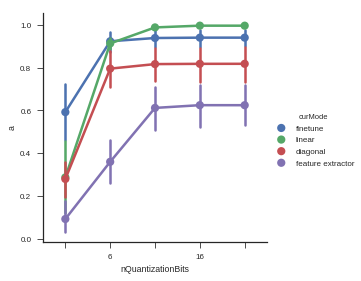

In [158]:
plt.close()
g = sns.factorplot(x = 'nQuantizationBits',y = 'a',hue='curMode',data=df_with_perf_max)
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=0) # set new l
#g.set(xticks=list(set(df_with_perf_max.nParams[::10])))
plt.show()

# Show Performance as function of no. of parameters 

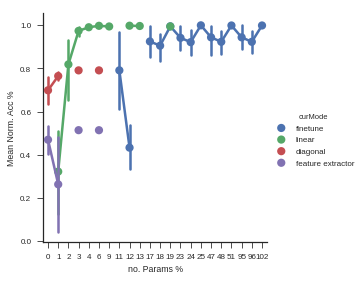

In [183]:
plt.close()
sns.set_style('ticks')
sns.set_context('paper')
g = sns.factorplot(x = 'nParams',y = 'a',hue='curMode',data=df_with_perf_max)
plt.gca().set(ylabel = 'Mean Norm. Acc %',xlabel='no. Params %')
plt.savefig('/home/amir/Dropbox/publications/2018/ICLR/figures/accuracy_vs_n_params.pdf');
plt.show()
#7777

In [70]:
for q in ax.get_xticklabels():
    print q

Text(0,0,u'0')
Text(1,0,u'')
Text(2,0,u'')
Text(3,0,u'3')
Text(4,0,u'')
Text(5,0,u'')
Text(6,0,u'9')
Text(7,0,u'')
Text(8,0,u'')
Text(9,0,u'13')
Text(10,0,u'')
Text(11,0,u'')
Text(12,0,u'19')
Text(13,0,u'')
Text(14,0,u'')
Text(15,0,u'25')
Text(16,0,u'')
Text(17,0,u'')
Text(18,0,u'51')
Text(19,0,u'')
Text(20,0,u'')
Text(21,0,u'102')


In [67]:
ax.get_xticks()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

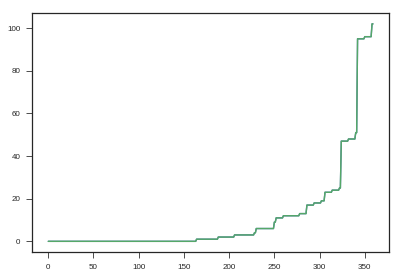

In [96]:
plt.plot(sorted(df_with_perf_max.nParams))
plt.show()

In [100]:
for q in ax.get_xticklabels():
    print q

Text(0,0,u'0')
Text(1,0,u'1')
Text(2,0,u'2')
Text(3,0,u'3')
Text(4,0,u'4')
Text(5,0,u'6')
Text(6,0,u'9')
Text(7,0,u'11')
Text(8,0,u'12')
Text(9,0,u'13')
Text(10,0,u'17')
Text(11,0,u'18')
Text(12,0,u'19')
Text(13,0,u'23')
Text(14,0,u'24')
Text(15,0,u'25')
Text(16,0,u'47')
Text(17,0,u'48')
Text(18,0,u'51')
Text(19,0,u'95')
Text(20,0,u'96')
Text(21,0,u'102')


In [161]:
d1 = df_with_perf_max
d1[(d1.curMode=='diagonal') & (d1.name=='Airc.')]

,name,finetune,controllerType,onlyLastLayer,nQuantizationBits,a,no_bn,curMode,nParams,nParams_fc,max_perf
300,Airc.,False,diagonal,False,8,0.438647,True,diagonal,0,25700,52.325233
301,Airc.,False,diagonal,False,8,0.438647,True,diagonal,0,25700,52.325233
302,Airc.,False,diagonal,False,16,0.434060,True,diagonal,0,25700,52.325233
303,Airc.,False,diagonal,False,16,0.434060,True,diagonal,0,25700,52.325233
304,Airc.,False,diagonal,False,32,0.434060,True,diagonal,0,25700,52.325233
305,Airc.,False,diagonal,False,32,0.434060,True,diagonal,0,25700,52.325233
306,Airc.,False,diagonal,False,6,0.411124,True,diagonal,0,25700,52.325233
307,Airc.,False,diagonal,False,6,0.411124,True,diagonal,0,25700,52.325233
308,Airc.,False,diagonal,False,4,0.104358,True,diagonal,0,25700,52.325233
309,Airc.,False,diagonal,False,4,0.104358,True,diagonal,0,25700,52.325233


In [162]:
plt.close()
sns.set_style('ticks')
sns.set_context('paper')
g = sns.factorplot(x = 'nParams',y = 'a',hue='curMode',data=df_with_perf_max.drop_duplicates(),col='name',col_wrap=3)
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%3 <> 0): labels[i] = '' # skip even labels
    #labels[-1]=''
    ax.set_xticklabels(labels, rotation=0) # set new l
    ax.set(ylabel='Normalized Accuracy %',xlabel='% Params')

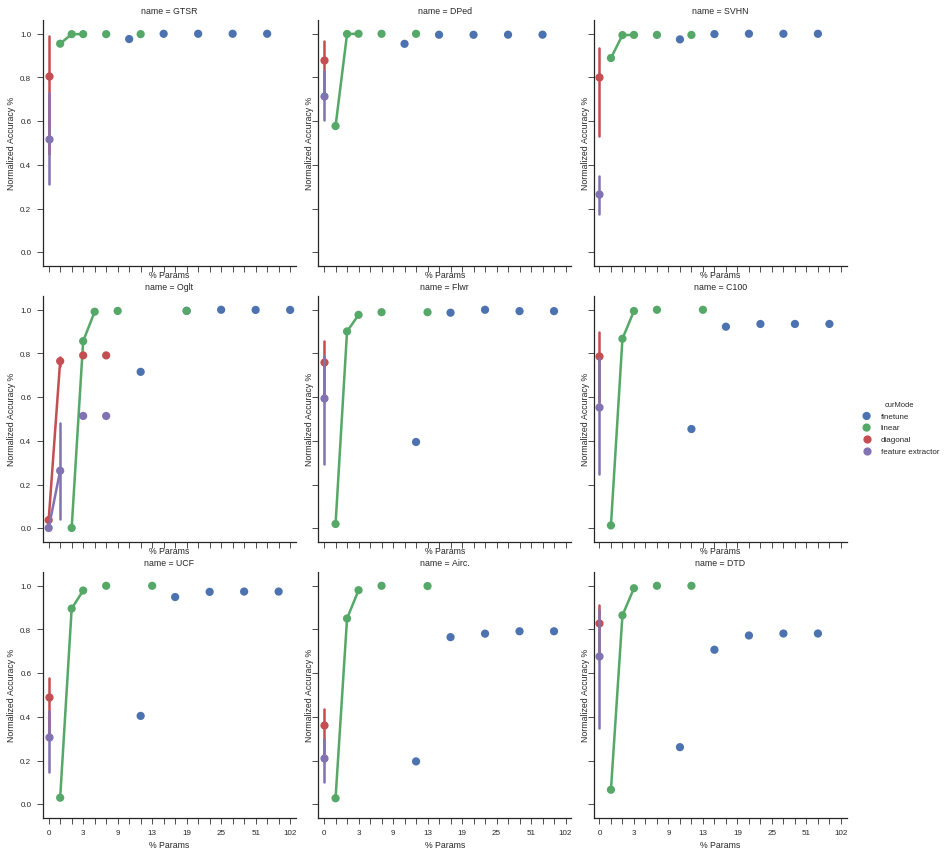

In [163]:
plt.show()

In [150]:
set(df_with_perf_max.curMode)

{'diagonal', 'feature extractor', 'finetune', 'linear'}

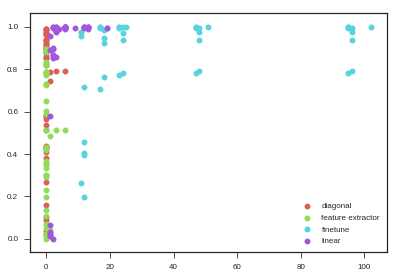

In [164]:
colors = sns.color_palette("hls", 4)
for i,M in enumerate(['diagonal', 'feature extractor', 'finetune', 'linear']):
    ddd = df_with_perf_max[df_with_perf_max.curMode==M].drop_duplicates()
    plt.scatter(ddd.nParams,ddd.a,color=colors[i],label=M)
plt.legend()
plt.show()
    

#g = sns.pointplot(x = 'nParams',y = 'a',hue='curMode',data=df_with_perf_max.drop_duplicates(),col='name',col_wrap=3)


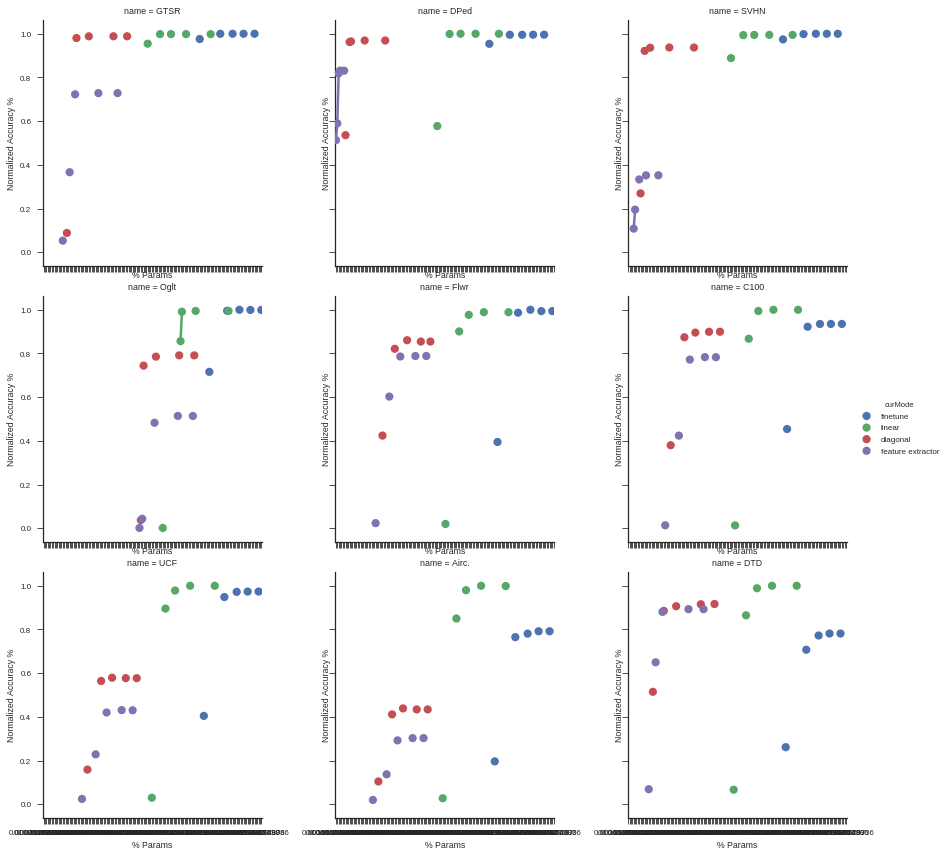

In [140]:
plt.show()

In [154]:
plt.close()
sns.set_style('ticks')
sns.set_context('paper')
g = sns.factorplot(x = 'nParams',y = 'a',hue='curMode',data=df_with_perf_max.drop_duplicates())

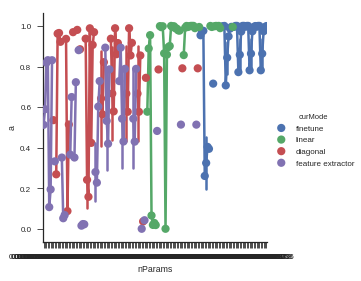

In [155]:
plt.show()

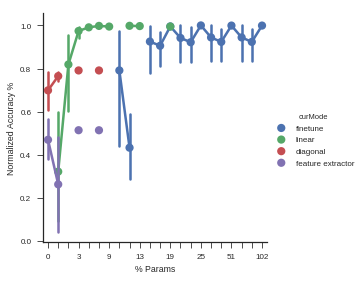

In [165]:
plt.close()
sns.set_style('ticks')
sns.set_context('paper')
g = sns.factorplot(x = 'nParams',y = 'a',hue='curMode',data=df_with_perf_max.drop_duplicates())
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%3 <> 0): labels[i] = '' # skip even labels
    #labels[-1]=''
    ax.set_xticklabels(labels, rotation=0) # set new l
    ax.set(ylabel='Normalized Accuracy %',xlabel='% Params')
    #ax.grid(b=True, which='major')
    #ax.grid(b=True, which='minor')
    #plt.axis('equal')
#77
#g.set(xticks=list(set(df_with_perf_max.nParams[::10])))
plt.savefig('/home/amir/Dropbox/publications/2018/ICLR/figures/accuracy_vs_n_params.pdf');
plt.show()

In [61]:
plt.close()
g=sns.lmplot(x = 'nParams',y = 'a',hue='curMode',data=df_df_with_perf_max,fit_reg=False,logx=Fal
g.ax.set_xscale('log')

plt.show()

SyntaxError: invalid syntax (<ipython-input-61-89d880d54184>, line 3)

In [47]:

z = df_with_perf[df_with_perf.name=='gtsrb'].sort_values('a').drop_duplicates()
g = sns.factorplot(x = 'nParams',hue='curMode',y = 'a',data=z)
#g.set(xticklabels=range(10),xticks=range(3))
plt.show()

ValueError: min() arg is an empty sequence

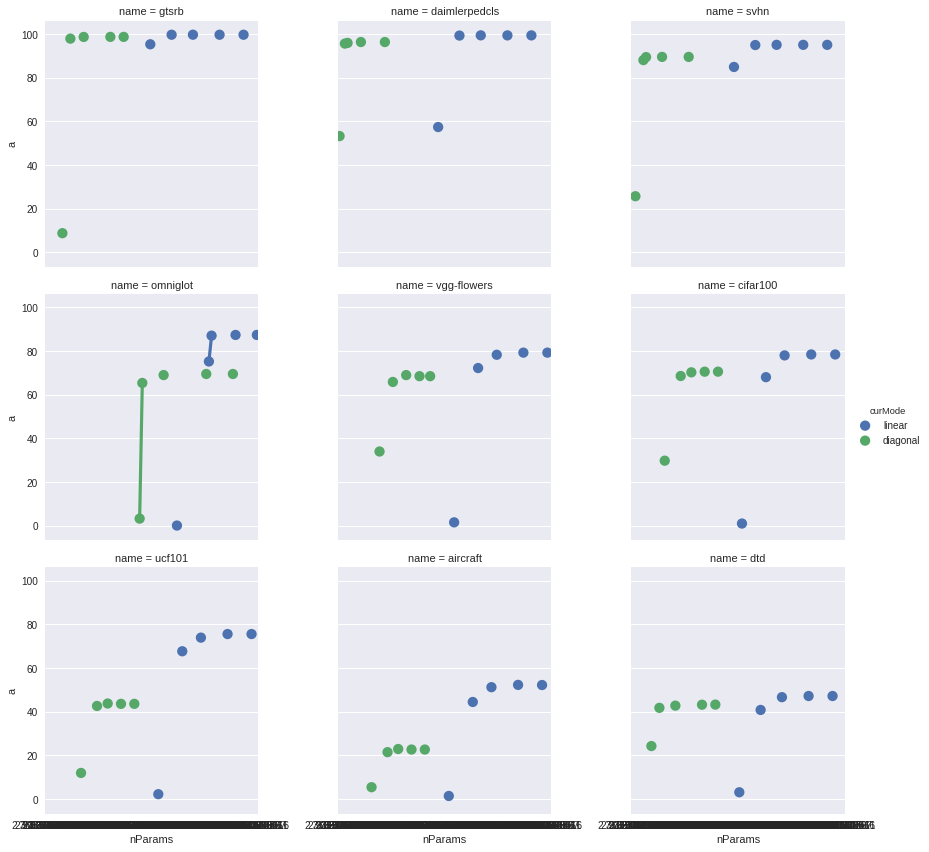

In [986]:
plt.show()

In [968]:
df_with_perf = pd.merge(df_all_results,df1)

In [971]:
df_with_perf[df_with_perf.name=='gtsrb'].drop_duplicates().sort_values('nQuantizationBits')

,name,finetune,controllerType,onlyLastLayer,nQuantizationBits,a,no_bn,curMode,nParams
18,gtsrb,False,linear,False,4,95.345575,True,linear,785451
48,gtsrb,False,diagonal,False,4,8.811528,True,diagonal,15099
8,gtsrb,True,linear,False,4,97.475134,False,ft,5857531
188,gtsrb,True,linear,True,4,5.304769,False,ft_last,11051
16,gtsrb,False,linear,False,6,99.719459,True,linear,785451
186,gtsrb,True,linear,True,6,36.585055,False,ft_last,11051
46,gtsrb,False,diagonal,False,6,97.934200,True,diagonal,15099
6,gtsrb,True,linear,False,6,99.872482,False,ft,5857531
10,gtsrb,False,linear,False,8,99.732211,True,linear,785451
44,gtsrb,False,diagonal,False,8,98.712063,True,diagonal,15099


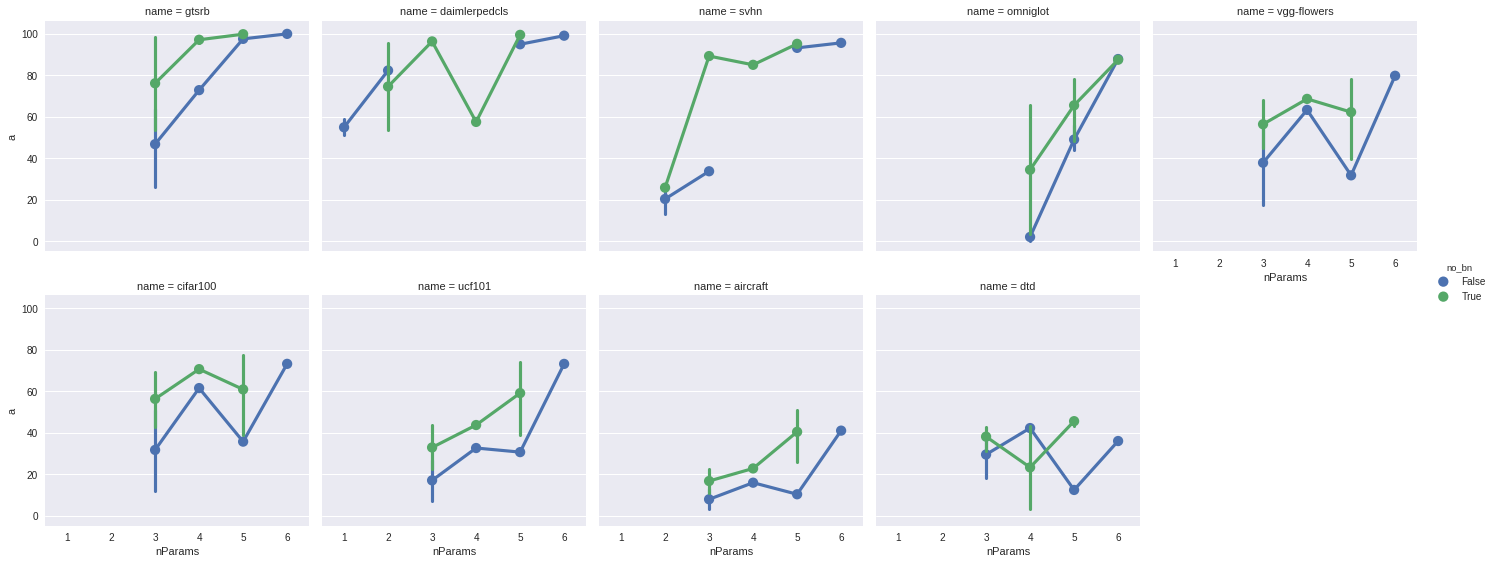

In [966]:
plt.show()

In [1248]:
df_with_perf = pd.merge(df_all_results,df1)
#df_with_perf.nParams.apply(np.log10)
df_with_perf.sort_values(['name','finetune','controllerType','onlyLastLayer','curMode']).drop_duplicates()
df_with_perf[df_with_perf.name=='gtsrb']

,name,finetune,controllerType,onlyLastLayer,nQuantizationBits,a,no_bn,curMode,nParams,nParams_fc
0,gtsrb,True,linear,False,32,99.885233,False,ft,5846480,11051
1,gtsrb,True,linear,False,32,99.885233,False,ft,5846480,11051
2,gtsrb,True,linear,False,8,99.885233,False,ft,5846480,11051
3,gtsrb,True,linear,False,8,99.885233,False,ft,5846480,11051
4,gtsrb,True,linear,False,16,99.885233,False,ft,5846480,11051
5,gtsrb,True,linear,False,16,99.885233,False,ft,5846480,11051
6,gtsrb,True,linear,False,6,99.872482,False,ft,5846480,11051
7,gtsrb,True,linear,False,6,99.872482,False,ft,5846480,11051
8,gtsrb,True,linear,False,4,97.475134,False,ft,5846480,11051
9,gtsrb,True,linear,False,4,97.475134,False,ft,5846480,11051


In [1249]:
plt.show()

In [883]:
# Now let's model the no, params
#df1

,name,finetune,controllerType,onlyLastLayer,no_bn,curMode,nParams
0,gtsrb,False,linear,False,True,linear,785451
1,gtsrb,True,linear,True,False,ft_last,11051
2,gtsrb,False,linear,False,True,linear,785451
3,gtsrb,True,linear,False,False,ft,5857531
4,gtsrb,False,diagonal,False,True,diagonal,15099
5,gtsrb,True,linear,True,False,ft_last,11051
6,gtsrb,False,diagonal,False,True,diagonal,15099
7,gtsrb,True,linear,False,False,ft,5857531
8,svhn,False,linear,False,True,linear,776970
9,svhn,True,linear,True,False,ft_last,2570


In [822]:
df1.sort_values(['name','finetune','controllerType','onlyLastLayer','curMode']).drop_duplicates()

,name,finetune,controllerType,onlyLastLayer,no_bn,curMode,nParams
60,aircraft,False,diagonal,False,True,diagonal,29748
56,aircraft,False,linear,False,True,linear,800100
59,aircraft,True,linear,False,False,ft,5872180
57,aircraft,True,linear,True,False,ft_last,25700
52,cifar100,False,diagonal,False,True,diagonal,29748
48,cifar100,False,linear,False,True,linear,800100
51,cifar100,True,linear,False,False,ft,5872180
49,cifar100,True,linear,True,False,ft_last,25700
20,daimlerpedcls,False,diagonal,False,True,diagonal,4562
16,daimlerpedcls,False,linear,False,True,linear,774914


In [803]:
#760100./5872180

0.12944085501466235

In [796]:
[r[-1] for r in model_param_count]

[800100, 25700, 800100, 5872180, 29748, 25700, 29748, 5872180]

In [ ]:
all_results.append((name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,
              anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,nQuantizationBits,a))

800100

In [832]:
model.block1.layer[0]

BasicBlock (
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (relu1): ReLU (inplace)
  (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu2): ReLU (inplace)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (convShortcut): Conv2d(16, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
)

In [868]:
countModelParameters(z.conv1.ctrl)

4096

In [863]:
z = model.block1.layer[0]
z.conv1.conv.weight.data.nelement()

9216

In [840]:
z.conv1.weight.data.nelement()

9216

In [844]:
z

BasicBlock (
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (relu1): ReLU (inplace)
  (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu2): ReLU (inplace)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (convShortcut): Conv2d(16, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
)

In [877]:
zip(p_before,p_after)

[(432, 256),
 (9216, 4096),
 (36864, 4096),
 (1024, 4096),
 (36864, 4096),
 (36864, 4096),
 (36864, 4096),
 (36864, 4096),
 (36864, 4096),
 (36864, 4096),
 (73728, 16384),
 (147456, 16384),
 (8192, 16384),
 (147456, 16384),
 (147456, 16384),
 (147456, 16384),
 (147456, 16384),
 (147456, 16384),
 (147456, 16384),
 (294912, 65536),
 (589824, 65536),
 (32768, 65536),
 (589824, 65536),
 (589824, 65536),
 (589824, 65536),
 (589824, 65536),
 (589824, 65536),
 (589824, 65536)]

In [875]:
p_before = []
p_after = []
for p in model.named_parameters():
    print p[0],':',
    if p[1].requires_grad:
        p_after.append(p[1].data.nelement())
        print p[1].data.nelement()
    elif 'conv.weight' in p[0]:
        p_before.append(p[1].data.nelement())
        print '(', p[1].data.nelement(),')'
    else:
        print '----------------'
        

conv1.conv.weight : ( 432 )
conv1.ctrl.P : 256
block1.layer.0.bn1.weight : ----------------
block1.layer.0.bn1.bias : ----------------
block1.layer.0.conv1.conv.weight : ( 9216 )
block1.layer.0.conv1.ctrl.P : 4096
block1.layer.0.bn2.weight : ----------------
block1.layer.0.bn2.bias : ----------------
block1.layer.0.conv2.conv.weight : ( 36864 )
block1.layer.0.conv2.ctrl.P : 4096
block1.layer.0.convShortcut.conv.weight : ( 1024 )
block1.layer.0.convShortcut.ctrl.P : 4096
block1.layer.1.bn1.weight : ----------------
block1.layer.1.bn1.bias : ----------------
block1.layer.1.conv1.conv.weight : ( 36864 )
block1.layer.1.conv1.ctrl.P : 4096
block1.layer.1.bn2.weight : ----------------
block1.layer.1.bn2.bias : ----------------
block1.layer.1.conv2.conv.weight : ( 36864 )
block1.layer.1.conv2.ctrl.P : 4096
block1.layer.2.bn1.weight : ----------------
block1.layer.2.bn1.bias : ----------------
block1.layer.2.conv1.conv.weight : ( 36864 )
block1.layer.2.conv1.ctrl.P : 4096
block1.layer.2.bn2.we

In [769]:
countModelParameters(z.conv1.ctrl)


4096

In [746]:
countModelParameters(model)/1e6

0.8073

In [741]:
countModelParameters(model)/1e6

0.8001

In [259]:
all_datasets['aircraft'].keys()

['dir_to_cat',
 'stats',
 'val',
 'file_name_to_id',
 'train',
 'nClasses',
 'test',
 'file_name_to_id_val',
 'cat_to_dir',
 'file_name_to_id_test']

In [297]:
a = torch.load('/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/best')

In [299]:
a['all_accuracies']

[13.710204081632654,
 17.048979591836734,
 17.322448979591837,
 17.155102040816328,
 18.448979591836736,
 18.738775510204082,
 19.39183673469388,
 14.977551020408164,
 20.283673469387754,
 17.76938775510204,
 17.959183673469386,
 19.248979591836736,
 19.60816326530612,
 17.648979591836735,
 18.781632653061223,
 17.987755102040815,
 18.80204081632653,
 19.191836734693876,
 19.82857142857143,
 19.13469387755102,
 16.787755102040816,
 19.426530612244896,
 20.385714285714286,
 17.887755102040817,
 19.93469387755102,
 19.65714285714286,
 15.683673469387756,
 17.283673469387754,
 18.73265306122449,
 19.31020408163265,
 18.36326530612245,
 18.02857142857143,
 19.475510204081633,
 18.279591836734692,
 41.13265306122449,
 40.67755102040816,
 41.17142857142857,
 41.912244897959184,
 43.50612244897959,
 42.94285714285714,
 42.265306122448976,
 42.64081632653061,
 42.84285714285714,
 43.08571428571429,
 42.926530612244896,
 43.183673469387756,
 43.28775510204082,
 44.11224489795919,
 43.3612244897

In [190]:
# mainloop4 : Speed of convergence. 
controlAnyway = True
optim_type = 'sgd'
isStandalone = False
weightDecay = 'default'
gamma = .1
my_base_lr = .1
noflip = ['gtsrb', 'omniglot', 'svhn']  # who is not to be flipped?
anisotropic_scaling = False
yellowfin = True
#finetune = False
#onlyLastLayer = False
bs = 64  # use 64 for small datasets.
from yellowfin import YFOptimizer
wnd_size = 40
last_lr = 1e-2  # default is 1e-2
drop_freq = 25  # default is 35
#drop_freq = 15  # default is 35
# for controllerType in ['diagonal']:
# for controllerType in ['diagonal']:
acc_results = []
for name in all_datasets.keys():
    if name == 'imagenet12':
        continue
 
    print name
    augment_flip = not name in noflip
    for controllerType in ['linear', 'diagonal']:
        for onlyLastLayer in [True,False]:
            sss = onlyLastLayer
            for finetune in [False,True]:
                onlyLastLayer=sss
                no_bn = True
                reset_bn = False
                rnk_ratio = .9
                assert not (no_bn and reset_bn)

                if finetune:
                    controllerType = 'linear'
                    no_bn = False
                else:
                    onlyLastLayer = False
                #if name <> 'ucf101':
                #    continue        
                nEpochs = 25 if name =='gtsrb' else 50

                sfx = generateSuffix(augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,
                          anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer)
                sfx+='_fc'    
                myModelDir = os.path.join(modelsBaseDir, name + sfx)
                perf,_ = loadLastCheckpoint(None, myModelDir, removeBest=True, verbose=False, onlyPerf=True)
                
                
                acc_results.append((name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,
                              anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,
                                   perf['all_accuracies']))

                
                
                
                print myModelDir

gtsrb
/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc
/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_ft_linear_ga_0.1_last_fc
/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc
/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_ft_linear_ga_0.1_fc
/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_no_bn_diagonal_ga_0.1_fc
/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_ft_linear_ga_0.1_last_fc
/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc
/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_ft_linear_ga_0.1_fc
svhn
/home/amir/models/decathlon_wide28/svhn_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc
/home/amir/models/decathlon_wide28/svhn_noflip_drop_fr_25_bs_64_YF_40_ft_linear_ga_0.1_last_fc
/home/amir/models/decathlon_wide28/svhn_noflip_dr

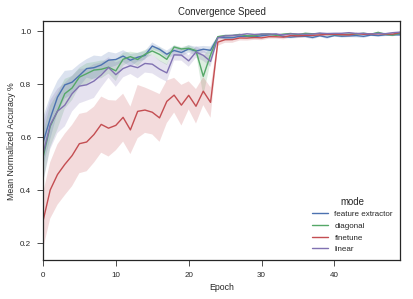

In [200]:

speeds = []
for a in acc_results:
    p = np.asarray(a[-1])
    # when do we reach 80% of accuracy? 
    T = p.max()*.99
    speeds.append(np.nonzero(p>T)[0][0])
fields = 'name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,perf'
fields = fields.split(',')

df = pd.DataFrame(acc_results,columns=fields)
df['speed']=np.asarray(speeds)+1
#df['speed'] = speeds


# Plot mean normalized accuracy over time for each of the modes.
# First, normalize all accuracies.
normalized_accs = []
for a in acc_results:
    p=a[-1]
    if len(p) < 50:
        p+=[max(p)]*25
    p = np.asarray(p)
    p = p/max(p)
    normalized_accs.append(p)
#df.drop_duplicates()
# add an extra column to specify mode: ft/ft_last , ctrl,ctrl_diag
fixNames(df)

df1 = df[['name','finetune','controllerType','onlyLastLayer','no_bn','curMode','speed']]

S = np.asarray(normalized_accs)
df2=pd.concat([df1,pd.DataFrame(S)],axis=1)
mmm = ['feature extractor','diagonal','finetune','linear']
dfs=[]
for m in mmm:
    D = df2[df2.curMode==m][['name','curMode']+range(50)]
    dfs.append(D)
dfs=pd.concat(dfs)

# This is for the tsplot.
sns.set_context("paper")
sns.set_style("ticks")
P = []
for k,v in dfs.iterrows():
    v = list(v)
    curName = v[0]
    curMode = v[1]
    curValues = v[2:]
    for i,p in enumerate(curValues):
        P.append((curName,curMode,i,p))
myDF = pd.DataFrame(data=P,columns=['name','mode','epoch','value'])

ax=sns.tsplot(data=myDF.drop_duplicates(),condition='mode',time='epoch',unit='name',value='value')
ax.set(xlabel='Epoch',ylabel='Mean Normalized Accuracy %',title='Convergence Speed')
plt.savefig('/home/amir/Dropbox/publications/2018/ICLR/figures/convergence speed.pdf');

plt.show()

In [197]:
DataFrame.cummax(axis=None, skipna=True, *args, **kwargs)[source]

,name,curMode,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,GTSR,linear,0.996803,0.958824,0.945524,0.947059,0.855371,0.958696,0.951151,0.981458,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,GTSR,linear,0.996803,0.958824,0.945524,0.947059,0.855371,0.958696,0.951151,0.981458,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,GTSR,linear,0.996803,0.958824,0.945524,0.947059,0.855371,0.958696,0.951151,0.981458,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,SVHN,linear,0.944646,0.972404,0.963822,0.942712,0.971477,0.969825,0.955000,0.973169,...,0.990130,0.993433,0.985577,0.992345,0.990049,0.987511,0.989969,0.987431,0.991217,0.997543
10,SVHN,linear,0.944646,0.972404,0.963822,0.942712,0.971477,0.969825,0.955000,0.973169,...,0.990130,0.993433,0.985577,0.992345,0.990049,0.987511,0.989969,0.987431,0.991217,0.997543
14,SVHN,linear,0.944646,0.972404,0.963822,0.942712,0.971477,0.969825,0.955000,0.973169,...,0.990130,0.993433,0.985577,0.992345,0.990049,0.987511,0.989969,0.987431,0.991217,0.997543
16,DPed,linear,0.928327,0.948170,0.964420,0.947657,0.964420,0.952959,0.965275,0.964420,...,0.994697,0.983921,0.996066,0.981697,0.978960,0.995724,0.992131,0.988710,0.993158,1.000000
18,DPed,linear,0.928327,0.948170,0.964420,0.947657,0.964420,0.952959,0.965275,0.964420,...,0.994697,0.983921,0.996066,0.981697,0.978960,0.995724,0.992131,0.988710,0.993158,1.000000
22,DPed,linear,0.928327,0.948170,0.964420,0.947657,0.964420,0.952959,0.965275,0.964420,...,0.994697,0.983921,0.996066,0.981697,0.978960,0.995724,0.992131,0.988710,0.993158,1.000000
24,Oglt,linear,0.244257,0.611608,0.783097,0.823076,0.848851,0.919165,0.938453,0.930388,...,0.991934,0.995441,0.994740,0.997019,0.993512,0.993337,0.991759,0.991057,0.991408,0.995090


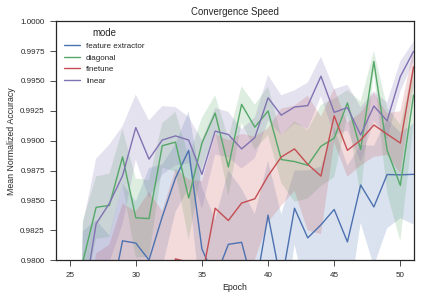

In [205]:
#8888
P = []
sns.set_context("paper")
sns.set_style("ticks")
for k,v in dfs.iterrows():
    v = list(v)
    curName = v[0]
    curMode = v[1]
    curValues = v[24:]
    for i,p in enumerate(curValues):
        P.append((curName,curMode,i+24,p))
myDF = pd.DataFrame(data=P,columns=['name','mode','epoch','value'])
ax=sns.tsplot(data=myDF.drop_duplicates(),condition='mode',time='epoch',unit='name',value='value')
ax.set(xlabel='Epoch',ylabel='Mean Normalized Accuracy %',title='Convergence Speed')
plt.ylim([.98,1])
plt.savefig('/home/amir/Dropbox/publications/2018/ICLR/figures/convergence speed zoom.pdf');


plt.show()

In [303]:
# mainloop3 - evaluation
doEvaluation=True

if doEvaluation:
    out = []
    print 'booyah - EVALUATING'
    controlAnyway = True
    optim_type = 'sgd'
    isStandalone = False
    weightDecay = 'default'
    gamma = .1
    my_base_lr = .1
    noflip = ['gtsrb', 'omniglot', 'svhn']  # who is not to be flipped?
    anisotropic_scaling = False
    yellowfin = True
    bs = 64  # use 64 for small datasets.
    from yellowfin import YFOptimizer
    wnd_size = 40
    last_lr = 1e-2  # default is 1e-2
    drop_freq = 25  # default is 35
    all_results = []
    for name in all_datasets.keys():
        #if name <> 'imagenet12':
        #    continue
        if name == 'imagenet12':
            isStandalone=True
        else:
            isStandalone=False
        #if name <> 'aircraft':
        #    continue
        print name
        augment_flip = not name in noflip
        controllerType = 'linear'
        onlyLastLayer = False
        finetune = False
        onlyLastLayer=False
        no_bn = True
        reset_bn = False
        rnk_ratio = .9
        assert not (no_bn and reset_bn)
        if finetune:
            controllerType = 'linear'
            no_bn = False
        else:
            onlyLastLayer = False    
        nEpochs = 25 if name =='gtsrb' else 50
        sfx = generateSuffix(augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,
                  anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer)
        sfx+='_fc'
        print name
        myModelDir = os.path.join(modelsBaseDir, name + sfx)    
        lastCheckpointpath = '{}/{}'.format(myModelDir,
                                            str(nEpochs - 1).zfill(4))
        if os.path.isfile(lastCheckpointpath) and False:
            print os.path.join(modelsBaseDir, name + sfx)
            print 'training already done - skipping'
            continue
            
        if not isStandalone:
            model = WideResNet(depth=28, widen_factor=4, num_classes=1000)
            # doTraining(n,model)
            modelDir = '/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/'
            _, model = loadLastCheckpoint(
                model, modelDir, removeBest=False, verbose=False, onlyPerf=False)                
            
            
        modelDir = os.path.join(modelsBaseDir, name + sfx)
        if name <> 'imagenet12':
            if isStandalone:
                newModel = ResNet18(all_datasets[name]['nClasses'])
                doTraining(name, newModel)
            else:
                newModel = deepcopy(model)
                new_n_classes = all_datasets[name]['nClasses']

                newModel.fc = nn.Linear(256, new_n_classes)
                newModel.fc.bias.data.zero_()
                if onlyLastLayer:
                    for p in newModel.parameters():
                        p.requires_grad=False
                    for p in newModel.fc.parameters():
                        p.requires_grad=True
                #nn.init.kaiming_uniform(newModel.linear.weight.data)
                if not finetune:
                    makeItControlled(model, newModel, controlAnyway,
                                     controllerType, verbose=False, rnk_ratio=rnk_ratio)
            model = newModel

        trainDir = os.path.join(baseDataDir, all_datasets[name]['train'])
        testDir = os.path.join(baseDataDir, all_datasets[name]['val'])
        tbs = bs if bs <> 128 else 128
        train_loader, test_loader = makeLoaders(trainDir, testDir, all_datasets[name]['stats'], augment_flip=augment_flip,
                                                augment_crop=True, train_batch_size=tbs)
        model.cuda()

        logger = Logger('runs/' + name + sfx)
        params = [p for p in model.parameters() if p.requires_grad]
        base_lr = 1e-1
        L = list(model.named_parameters())
        base_params = []
        classifer_params = []
        for a, b in L:
            if not b.requires_grad:
                continue
            if 'linear' in a:
                classifer_params.append(b)
            else:
                base_params.append(b)

        if optim_type == 'adam':
            base_lr = 1e-3
            # , momentum=0.9, weight_decay=5e-4)
            optimizer = optim.Adam(params=params)
        else:
            if not isStandalone:
                wd = 5e-4
                if weightDecay <> 'default':
                    wd = weightDecay
                lastLR = 1e-2
                if last_lr <> 1e-2:
                    lastLR = last_lr
                # optimizer = optim.SGD([{'params': base_params},{'params': classifer_params, 'lr': lastLR}]
                #                  ,lr=base_lr, momentum=0.9, weight_decay=wd)

                #optimizer = optim.SGD(params= base_params,lr=base_lr, momentum=0.9,nesterov=False, weight_decay=wd)
                base_lr = my_base_lr
                optimizer = optim.SGD(
                    params=params, lr=base_lr, momentum=0.9, nesterov=False, weight_decay=wd)
            else:
                if name <> 'imagenet12':
                    optimizer = optim.SGD(params=model.parameters(
                    ), lr=base_lr, momentum=0.9, weight_decay=5e-4)
                
                
                
        if yellowfin and name <> 'imagenet12':
            base_lr = .5
            optimizer = YFOptimizer(
                params, lr=base_lr, mu=0.0, weight_decay=5e-4, clip_thresh=2.0, curv_win_width=wnd_size)
            optimizer._sparsity_debias = True

        df_ = drop_freq if drop_freq <> 35 else 35        
        adjust_learning_rate_fn = adjust_learning_rate

        if no_bn:
            freezeBN(model, no_bn)
        if name <> 'imagenet12':
            trainAndTest(model, optimizer, modelDir, epochs=nEpochs, train_loader=train_loader, model_save_freq=20,  # was 150 epochs
                         test_loader=test_loader, adjust_learning_rate=adjust_learning_rate_fn,
                         base_lr=base_lr, lr_drop_freq=df_, logger=logger, gamma=gamma)
        else:
            model = WideResNet(depth=28, widen_factor=4, num_classes=1000)
        # doTraining(n,model)
            modelDir = '/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/'
            _, model = loadLastCheckpoint(model, modelDir, removeBest=False, verbose=False, onlyPerf=False) 

        if True:
            evaluationPath = modelDir + '.res'
            if os.path.isfile(evaluationPath):
                res = pickle.load(open(evaluationPath))
            else:
                # TODO : REMEMBER TO EVALUATE USING THE BEST VALIDATION MODEL, NOT THE LAST ONE.
                res = evaluateModel(name, model, 'val')
                pickle.dump(res, open(evaluationPath, 'wb'))
            mode='val'
            file_name_to_id = all_datasets[name]['file_name_to_id'+'_'+mode]
            for f,r in zip(file_name_to_id,res):                
                out.append({'image_id':f['id'],'category_id':r})
        #del newModel

booyah - EVALUATING
gtsrb
gtsrb
normalize True
loading from /home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc/0024
=> loaded checkpoint '/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc/0024'
svhn
svhn
normalize True
loading from /home/amir/models/decathlon_wide28/svhn_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc/0049
=> loaded checkpoint '/home/amir/models/decathlon_wide28/svhn_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc/0049'
daimlerpedcls
daimlerpedcls
normalize True
loading from /home/amir/models/decathlon_wide28/daimlerpedcls_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc/0049
=> loaded checkpoint '/home/amir/models/decathlon_wide28/daimlerpedcls_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc/0049'
omniglot
omniglot
normalize True
loading from /home/amir/models/decathlon_wide28/omniglot_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc/0049
=> loaded checkpoint '/home/amir/mo

In [301]:
evaluationPath

'/home/amir/models/decathlon_wide28/imagenet12_SA_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc.res'

In [304]:
json.dump(out, open(os.path.join(
        homeDir, 'decathlon/decathlon-1.0/results/results_val_wd28.json'), 'w'))
#len(out)

In [294]:
#len(set([p['category_id'] for p in out]))

2226

In [18]:
doFullTraining = False

In [33]:
#copy_tree('/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/val1/','/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/')

['/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0048/000003.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0048/000011.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0048/000019.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0048/000008.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0048/000002.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0048/000006.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0048/000004.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0048/000015.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0048/000014.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0048/000007.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0088/000010.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train1/0088/000018.jpg',
 '/home/amir/decathlon/decathlon-1.0-data/vgg-flower

In [80]:
import fnmatch
import os
def getFileNames(d,sfx='*.jpg'):
    matches = []
    for root, dirnames, filenames in os.walk(d):
        for filename in fnmatch.filter(filenames, sfx):
            matches.append(os.path.join(root, filename))
    return ['/'.join(m.split('/')[-2:]) for m in matches]

In [81]:
sTest.intersection(sTrain)

{'0099/000050.jpg',
 '0055/000060.jpg',
 '0001/000049.jpg',
 '0061/000042.jpg',
 '0043/000061.jpg',
 '0051/000063.jpg',
 '0079/000045.jpg',
 '0051/000065.jpg',
 '0093/000045.jpg',
 '0019/000040.jpg',
 '0094/000055.jpg',
 '0050/000036.jpg',
 '0038/000058.jpg',
 '0064/000049.jpg',
 '0021/000064.jpg',
 '0087/000044.jpg',
 '0051/000060.jpg',
 '0031/000042.jpg',
 '0005/000046.jpg',
 '0077/000042.jpg',
 '0056/000034.jpg',
 '0040/000044.jpg',
 '0080/000037.jpg',
 '0061/000052.jpg',
 '0074/000065.jpg',
 '0010/000037.jpg',
 '0097/000063.jpg',
 '0059/000066.jpg',
 '0034/000055.jpg',
 '0080/000044.jpg',
 '0020/000060.jpg',
 '0097/000036.jpg',
 '0087/000049.jpg',
 '0070/000045.jpg',
 '0048/000066.jpg',
 '0024/000039.jpg',
 '0076/000056.jpg',
 '0024/000040.jpg',
 '0016/000050.jpg',
 '0015/000037.jpg',
 '0032/000039.jpg',
 '0056/000062.jpg',
 '0089/000034.jpg',
 '0012/000048.jpg',
 '0087/000054.jpg',
 '0017/000062.jpg',
 '0041/000063.jpg',
 '0083/000041.jpg',
 '0043/000044.jpg',
 '0032/000047.jpg',


In [75]:
sTrain

{'0099/000050.jpg',
 '0055/000060.jpg',
 '0001/000049.jpg',
 '0061/000042.jpg',
 '0043/000061.jpg',
 '0051/000063.jpg',
 '0079/000045.jpg',
 '0022/000043.jpg',
 '0029/000057.jpg',
 '0093/000045.jpg',
 '0019/000040.jpg',
 '0094/000055.jpg',
 '0017/000043.jpg',
 '0050/000036.jpg',
 '0038/000058.jpg',
 '0064/000049.jpg',
 '0046/000049.jpg',
 '0087/000044.jpg',
 '0029/000052.jpg',
 '0005/000046.jpg',
 '0077/000042.jpg',
 '0040/000044.jpg',
 '0080/000037.jpg',
 '0061/000041.jpg',
 '0060/000053.jpg',
 '0061/000058.jpg',
 '0010/000037.jpg',
 '0097/000063.jpg',
 '0059/000066.jpg',
 '0034/000055.jpg',
 '0080/000044.jpg',
 '0020/000060.jpg',
 '0001/000066.jpg',
 '0087/000049.jpg',
 '0070/000045.jpg',
 '0048/000066.jpg',
 '0037/000035.jpg',
 '0076/000056.jpg',
 '0024/000040.jpg',
 '0016/000050.jpg',
 '0015/000037.jpg',
 '0032/000039.jpg',
 '0056/000062.jpg',
 '0089/000034.jpg',
 '0012/000048.jpg',
 '0087/000054.jpg',
 '0017/000062.jpg',
 '0041/000063.jpg',
 '0083/000041.jpg',
 '0051/000048.jpg',


In [91]:
from distutils.dir_util import copy_tree
for k,v in all_datasets.iteritems():
    if k == 'imagenet12':
        continue
    print k
    
    #train_val = 
    name=k
    trainDir_orig = os.path.join(baseDataDir, all_datasets[name]['train'])
    trainDir = os.path.join(baseDataDir, all_datasets[name]['train']+'_val')
    testDir = os.path.join(baseDataDir, all_datasets[name]['val'])
    
    
    if os.path.isdir(trainDir):
        print trainDir
        print '!!!'
        continue
    #continue
    sTrain = set(getFileNames(testDir))
    sTest = set(getFileNames(trainDir_orig))
    assert(len(sTrain.intersection(sTest))==0)
    
        
    shutil.copytree(trainDir_orig,trainDir)
    copy_tree(testDir,trainDir)
    print trainDir_orig
    print trainDir
    print testDir
    
    
    
    

gtsrb
/home/amir/decathlon/decathlon-1.0-data/gtsrb/train_val
!!!
svhn
/home/amir/decathlon/decathlon-1.0-data/svhn/train_val
!!!
daimlerpedcls
/home/amir/decathlon/decathlon-1.0-data/daimlerpedcls/train_val
!!!
omniglot
/home/amir/decathlon/decathlon-1.0-data/omniglot/train_val
!!!
dtd
/home/amir/decathlon/decathlon-1.0-data/dtd/train_val
!!!
vgg-flowers
/home/amir/decathlon/decathlon-1.0-data/vgg-flowers/train_val
!!!
ucf101
/home/amir/decathlon/decathlon-1.0-data/ucf101/train_val
!!!
aircraft
/home/amir/decathlon/decathlon-1.0-data/aircraft/train_val
!!!
cifar100
/home/amir/decathlon/decathlon-1.0-data/cifar100/train_val
!!!


In [95]:
doFullTraining=True

In [316]:
# mainloop2 - full training
if doFullTraining:
    out = []
    print 'booyah'
    controlAnyway = True
    optim_type = 'sgd'
    isStandalone = False
    weightDecay = 'default'
    gamma = .1
    my_base_lr = .1
    noflip = ['gtsrb', 'omniglot', 'svhn']  # who is not to be flipped?
    anisotropic_scaling = False
    yellowfin = True

    bs = 64  # use 64 for small datasets.
    from yellowfin import YFOptimizer
    wnd_size = 40
    last_lr = 1e-2  # default is 1e-2
    drop_freq = 25  # default is 35
    all_results = []
    for name in all_datasets.keys():
        
        #if name <> 'aircraft':
        #    continue
        print name
        augment_flip = not name in noflip
        controllerType = 'linear'
        onlyLastLayer = False
        finetune = False
        onlyLastLayer=False
        no_bn = True
        reset_bn = False
        rnk_ratio = .9
        assert not (no_bn and reset_bn)
        if finetune:
            controllerType = 'linear'
            no_bn = False
        else:
            onlyLastLayer = False    
        nEpochs = 25 if name =='gtsrb' else 50
        sfx = generateSuffix(augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,
                  anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer)
        sfx+='_fc_final'
        print name
        myModelDir = os.path.join(modelsBaseDir, name + sfx)    
        lastCheckpointpath = '{}/{}'.format(myModelDir,
                                            str(nEpochs - 1).zfill(4))
        if os.path.isfile(lastCheckpointpath) and False:
            print os.path.join(modelsBaseDir, name + sfx)
            print 'training already done - skipping'
            continue
            
        if not isStandalone:
            model = WideResNet(depth=28, widen_factor=4, num_classes=1000)
            # doTraining(n,model)
            modelDir = '/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/'
            _, model = loadLastCheckpoint(
                model, modelDir, removeBest=False, verbose=False, onlyPerf=False)
        
        modelDir = os.path.join(modelsBaseDir, name + sfx)
        if name <> 'imagenet12':
            if isStandalone:
                newModel = ResNet18(all_datasets[name]['nClasses'])
                doTraining(name, newModel)
            else:
                newModel = deepcopy(model)
                new_n_classes = all_datasets[name]['nClasses']

                newModel.fc = nn.Linear(256, new_n_classes)
                newModel.fc.bias.data.zero_()
                if onlyLastLayer:
                    for p in newModel.parameters():
                        p.requires_grad=False
                    for p in newModel.fc.parameters():
                        p.requires_grad=True
                #nn.init.kaiming_uniform(newModel.linear.weight.data)
                if not finetune:
                    makeItControlled(model, newModel, controlAnyway,
                                     controllerType, verbose=False, rnk_ratio=rnk_ratio)
            model = newModel

        trainDir = os.path.join(baseDataDir, all_datasets[name]['train'])#
        if name <> 'imagenet12':
            trainDir+='_val'
        testDir = os.path.join(baseDataDir, all_datasets[name]['val'])
        tbs = bs if bs <> 128 else 128        
        train_loader, test_loader = makeLoaders(trainDir, testDir, all_datasets[name]['stats'], augment_flip=augment_flip,
                                                augment_crop=True, train_batch_size=tbs)
        model.cuda()

        logger = Logger('runs/' + name + sfx)
        params = [p for p in model.parameters() if p.requires_grad]
        base_lr = 1e-1
        L = list(model.named_parameters())
        base_params = []
        classifer_params = []
        for a, b in L:
            if not b.requires_grad:
                continue
            if 'linear' in a:
                classifer_params.append(b)
            else:
                base_params.append(b)

        if optim_type == 'adam':
            base_lr = 1e-3
            # , momentum=0.9, weight_decay=5e-4)
            optimizer = optim.Adam(params=params)
        else:
            if not isStandalone:
                wd = 5e-4
                if weightDecay <> 'default':
                    wd = weightDecay
                lastLR = 1e-2
                if last_lr <> 1e-2:
                    lastLR = last_lr
                # optimizer = optim.SGD([{'params': base_params},{'params': classifer_params, 'lr': lastLR}]
                #                  ,lr=base_lr, momentum=0.9, weight_decay=wd)

                #optimizer = optim.SGD(params= base_params,lr=base_lr, momentum=0.9,nesterov=False, weight_decay=wd)
                base_lr = my_base_lr
                optimizer = optim.SGD(
                    params=params, lr=base_lr, momentum=0.9, nesterov=False, weight_decay=wd)
            else:
                if name <> 'imagenet12':
                    optimizer = optim.SGD(params=model.parameters(
                    ), lr=base_lr, momentum=0.9, weight_decay=5e-4)
        if yellowfin and name <> 'imagenet12':
            base_lr = .5
            optimizer = YFOptimizer(
                params, lr=base_lr, mu=0.0, weight_decay=5e-4, clip_thresh=2.0, curv_win_width=wnd_size)
            optimizer._sparsity_debias = True

        df_ = drop_freq if drop_freq <> 35 else 35        
        adjust_learning_rate_fn = adjust_learning_rate

        if no_bn:
            freezeBN(model, no_bn)
        if name <> 'imagenet12':
            trainAndTest(model, optimizer, modelDir, epochs=nEpochs, train_loader=train_loader, model_save_freq=20,  # was 150 epochs
                         test_loader=test_loader, adjust_learning_rate=adjust_learning_rate_fn,
                         base_lr=base_lr, lr_drop_freq=df_, logger=logger, gamma=gamma)
        else:
            model = WideResNet(depth=28, widen_factor=4, num_classes=1000)
        # doTraining(n,model)
            modelDir = '/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd'
            _, model = loadLastCheckpoint(model, modelDir, removeBest=False, verbose=False, onlyPerf=False) 
        
        if True:
            mode='test'
            evaluationPath = modelDir + '_test.res'
            if os.path.isfile(evaluationPath):
                res = pickle.load(open(evaluationPath))
            else:
                # TODO : REMEMBER TO EVALUATE USING THE BEST VALIDATION MODEL, NOT THE LAST ONE.                
                res = evaluateModel(name, model, mode)                
                pickle.dump(res, open(evaluationPath, 'wb'))            
            file_name_to_id = all_datasets[name]['file_name_to_id'+'_'+mode]
            for f,r in zip(file_name_to_id,res):                
                out.append({'image_id':f['id'],'category_id':r})
        #del newModel

booyah
gtsrb
gtsrb
normalize True
loading from /home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc_final/0024
=> loaded checkpoint '/home/amir/models/decathlon_wide28/gtsrb_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc_final/0024'
gtsrb
0.0  % done
5.05050505051  % done
10.101010101  % done
15.1515151515  % done
20.202020202  % done
25.2525252525  % done
30.303030303  % done
35.3535353535  % done
40.404040404  % done
45.4545454545  % done
50.5050505051  % done
55.5555555556  % done
60.6060606061  % done
65.6565656566  % done
70.7070707071  % done
75.7575757576  % done
80.8080808081  % done
85.8585858586  % done
90.9090909091  % done
95.9595959596  % done
svhn
svhn
normalize True
loading from /home/amir/models/decathlon_wide28/svhn_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc_final/0049
=> loaded checkpoint '/home/amir/models/decathlon_wide28/svhn_noflip_drop_fr_25_bs_64_YF_40_no_bn_linear_ga_0.1_fc_final/0049'
svhn
0.0  % done
2.

'/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/'

In [312]:
evaluationPath

'/home/amir/models/decathlon_wide28/imagenet12_wide28_sgd/.res'

In [317]:
json.dump(out, open(os.path.join(
        homeDir, 'decathlon/decathlon-1.0/test_results/results_test.json'), 'w'))
#len(out)

In [11]:
#pickle.dump(all_results,open('all_results.pkl','wb'))
import pickle
all_results = pickle.load(open('all_results.pkl'))

In [7]:
# TODO : Go over all results and for each directory D if there exists both D_fc and D (no _fc) , remove D. 

In [8]:
#df.augment_flip.unique()

In [12]:
import pandas as pd
fields = 'name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,nQuantizationBits,a'
fields = fields.split(',')
df = pd.DataFrame(all_results,columns=fields)
for f in fields:
    print f,df[(df.name=='aircraft') & (df.nQuantizationBits==32)][f].unique()

name ['aircraft']
augment_flip [True]
controlAnyway [True]
optim_type ['sgd']
isStandalone [False]
weightDecay ['default']
last_lr [ 0.01]
drop_freq [25]
anisotropic_scaling [False]
yellowfin [True]
finetune [False True]
no_bn [True False]
controllerType ['linear' 'diagonal']
reset_bn [False]
gamma [ 0.1]
wnd_size [40]
rnk_ratio [ 0.9]
my_base_lr [ 0.1]
onlyLastLayer [False True]
nQuantizationBits [32]
a [ 52.26522652  15.84158416  41.43414341  22.71227123]


In [329]:
#df[(df.name=='aircraft') & (df.nQuantizationBits==32)].drop_duplicates()

,name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,anisotropic_scaling,yellowfin,...,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,nQuantizationBits,a
284,aircraft,True,True,sgd,False,default,0.01,25,False,True,...,True,linear,False,0.1,40,0.9,0.1,False,32,52.265227
289,aircraft,True,True,sgd,False,default,0.01,25,False,True,...,False,linear,False,0.1,40,0.9,0.1,True,32,15.841584
299,aircraft,True,True,sgd,False,default,0.01,25,False,True,...,False,linear,False,0.1,40,0.9,0.1,False,32,41.434143
304,aircraft,True,True,sgd,False,default,0.01,25,False,True,...,True,diagonal,False,0.1,40,0.9,0.1,False,32,22.712271


In [12]:
df.drop_duplicates()

,name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,anisotropic_scaling,yellowfin,...,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,nQuantizationBits,a
0,gtsrb,False,True,sgd,False,default,0.01,25,False,True,...,True,linear,False,0.1,40,0.9,0.1,False,4,95.345575
1,gtsrb,False,True,sgd,False,default,0.01,25,False,True,...,True,linear,False,0.1,40,0.9,0.1,False,6,99.719459
2,gtsrb,False,True,sgd,False,default,0.01,25,False,True,...,True,linear,False,0.1,40,0.9,0.1,False,8,99.732211
3,gtsrb,False,True,sgd,False,default,0.01,25,False,True,...,True,linear,False,0.1,40,0.9,0.1,False,16,99.719459
4,gtsrb,False,True,sgd,False,default,0.01,25,False,True,...,True,linear,False,0.1,40,0.9,0.1,False,32,99.719459
5,gtsrb,False,True,sgd,False,default,0.01,25,False,True,...,False,linear,False,0.1,40,0.9,0.1,True,4,5.304769
6,gtsrb,False,True,sgd,False,default,0.01,25,False,True,...,False,linear,False,0.1,40,0.9,0.1,True,6,36.585055
7,gtsrb,False,True,sgd,False,default,0.01,25,False,True,...,False,linear,False,0.1,40,0.9,0.1,True,8,72.200969
8,gtsrb,False,True,sgd,False,default,0.01,25,False,True,...,False,linear,False,0.1,40,0.9,0.1,True,16,72.736547
9,gtsrb,False,True,sgd,False,default,0.01,25,False,True,...,False,linear,False,0.1,40,0.9,0.1,True,32,72.749299


In [22]:
abbr = {'gtsrb':'GTSR',
 'svhn':'SVHN',
 'daimlerpedcls':'DPed',
 'omniglot':'Oglt',
 'dtd':'DTD',
 'vgg-flowers':'Flwr',
 'cifar100':'C100',
 'aircraft':'Airc.',
 'ucf101':'UCF',
 'imagenet12':'ImNet'}

def fixNames(df):
    # fix names, modes
    names = df.name
    df.name = map(abbr.get,names)
    
    modeFix = {'ft':'finetune',
               'ft_last':'feature extractor',
               'diagonal':'diagonal',
               'linear':'linear'}
    if not 'curMode' in df:
        # add an extra column to specify mode: ft/ft_last , ctrl,ctrl_diag
        modes = []
        for r,v in df.iterrows():
            if v['finetune']:
                s = 'ft'
                if v['onlyLastLayer']:
                    s+='_last'
            else:
                s = v['controllerType']
            modes.append(s)
            #print s
        df['curMode']=modes
        
    modes = df.curMode
    df.curMode = map(modeFix.get,modes)
               
    

In [20]:
'name' in df1

True

In [166]:


import pandas as pd
#fields = 'name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,nQuantizationBits,a'
fields = 'name,augment_flip,controlAnyway,optim_type,isStandalone,weightDecay,last_lr,drop_freq,anisotropic_scaling,yellowfin,finetune,no_bn,controllerType,reset_bn,gamma,wnd_size,rnk_ratio,my_base_lr,onlyLastLayer,nQuantizationBits,a'
fields = fields.split(',')
df = pd.DataFrame(all_results,columns=fields).drop_duplicates()
fixNames(df)
df1 = df[['name','finetune','controllerType','onlyLastLayer','nQuantizationBits','a','no_bn','curMode']]
df1 = df1.sort_values(['a'],ascending=False).drop_duplicates()
df_all_results = df1

# Do some analysis.

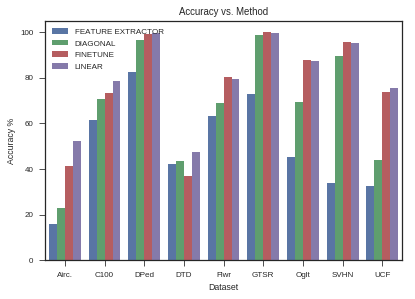

In [184]:
import seaborn as sns
# First, show how the method affects the precision.
dfs = []
mmm = ['feature extractor','diagonal','finetune','linear']
for m in mmm:
    dfs.append(df1[df1.curMode==m].groupby('name').max().reset_index('name'))
dfs=pd.concat(dfs)
#fig, ax = plt.subplots()
# the size of A4 paper
#fig.set_size_inches(11.7, 8.27)
plt.close()
sns.set_context("paper")
sns.set_style("ticks")
#sns.set(font_scale=2)
dfs.curMode=dfs.curMode.apply(str.upper);
#dfs.name=dfs.name.apply(str.upper);
dfs=dfs.rename(columns={'curMode':'mode'})
ax=sns.barplot(x="name", y="a", hue="mode", data=dfs)
ax.set(xlabel='Dataset',ylabel='Accuracy %',title='Accuracy vs. Method')
labels = ax.get_xticklabels() # get x labels
ax.set_xticklabels(labels, rotation=0) # set new l
plt.legend(loc='upper left')

plt.savefig('/home/amir/Dropbox/publications/2018/ICLR/figures/accuracy_vs_method.pdf');
plt.show()

In [49]:
dfs

,name,finetune,controllerType,onlyLastLayer,nQuantizationBits,a,no_bn,curMode
0,AIRCRAFT,True,linear,True,32,15.841584,False,FT_LAST
1,CIFAR100,True,linear,True,32,61.470000,False,FT_LAST
2,DAIMLERPEDCLS,True,linear,True,32,82.653061,False,FT_LAST
3,DTD,True,linear,True,32,42.180851,False,FT_LAST
4,GTSRB,True,linear,True,32,72.749299,False,FT_LAST
5,OMNIGLOT,True,linear,True,32,45.178681,False,FT_LAST
6,SVHN,True,linear,True,32,33.648233,False,FT_LAST
7,UCF101,True,linear,True,32,32.581967,False,FT_LAST
8,VGG-FLOWERS,True,linear,True,32,63.235294,False,FT_LAST
0,AIRCRAFT,False,diagonal,False,32,22.952295,True,DIAGONAL


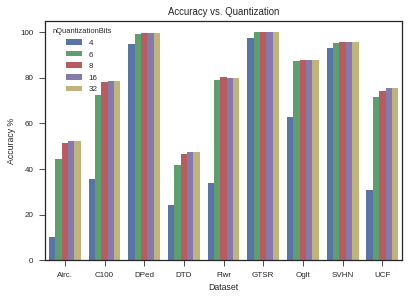

In [185]:
## now, let's look at the effects of quantization.
dfs = []
sns.set(font_scale=1)
mmm = [4,6,8,16,32]
for m in mmm:
    dfs.append(df1[df1.nQuantizationBits==m].groupby('name').max().reset_index('name'))
dfs=pd.concat(dfs)
names = dfs.name
sns.set_context("paper")
sns.set_style('ticks')
#dfs.name = map(abbr.get,names)
ax=sns.barplot(x="name", y="a", hue="nQuantizationBits", data=dfs)
ax.set(xlabel='Dataset',ylabel='Accuracy %',title='Accuracy vs. Quantization')
plt.savefig('/home/amir/Dropbox/publications/2018/ICLR/figures/accuracy_vs_quantization.pdf');
plt.show()

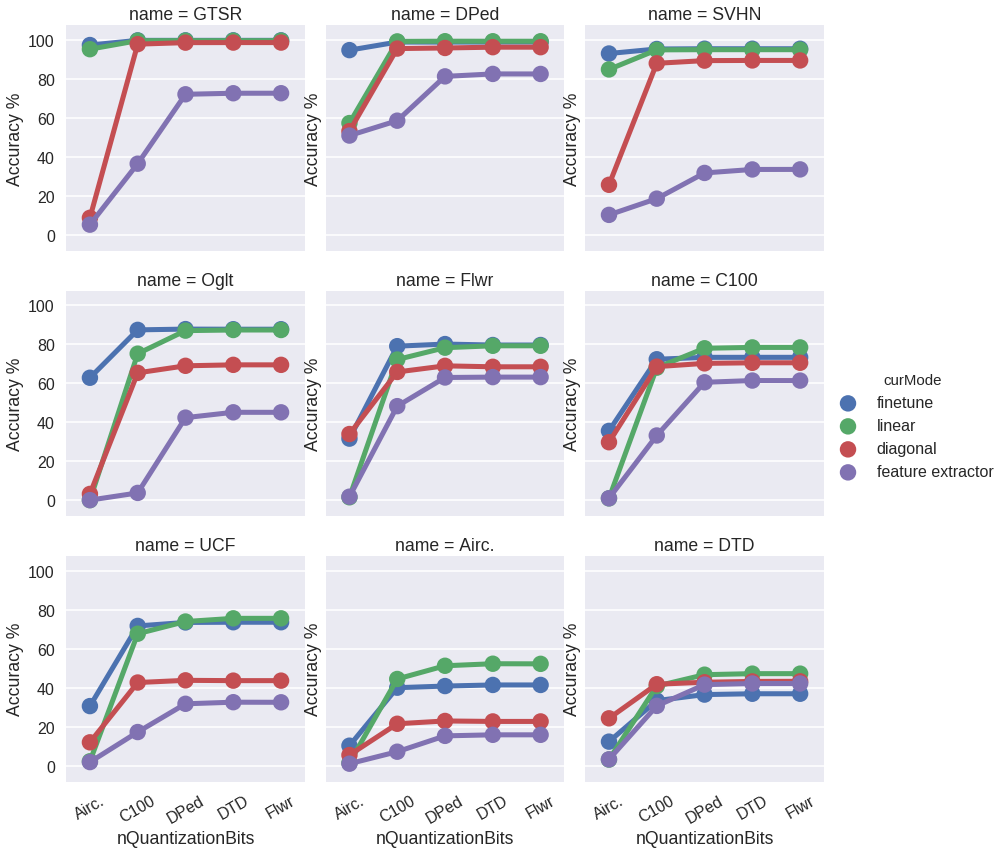

In [170]:
## now, let's look at the effects of quantization.
dfs = []
sns.set(font_scale=1)
mmm = [4,6,8,16,32]
#for m in mmm:
#    dfs.append(df1[df1.nQuantizationBits==m].groupby('name').max().reset_index('name'))
#dfs=pd.concat(dfs)
#names = dfs.name
sns.set_context("poster")
#dfs.name = map(abbr.get,names)
ax=sns.factorplot(x="nQuantizationBits", y="a", hue="curMode", col='name',data=df1,col_wrap=3)
ax.set(ylabel='Accuracy %')#,title='Accuracy vs. Quantization')
#########
ax.set_xticklabels(labels, rotation=30)
#plt.savefig('/home/amir/Dropbox/publications/2018/ICLR/figures/accuracy_vs_quantization.pdf');
plt.show()

In [24]:
modelsBaseDir = '/home/amir/models/decathlon_18/'  # _init

In [25]:
# find the best performing net for each key.
for k in all_datasets.keys():
    print k
    g = glob.glob(os.path.join(modelsBaseDir, '*' + k + '*'))
    g = [a for a in g if os.path.isdir(
        a) and '_SA' not in a and '_MD' not in a]
    p = 0
    bestDir = ''
    for g_ in g:
        f = os.path.join(g_, 'best')
        if not os.path.isfile(f):
            continue
        a = torch.load(f)
        acc = a['best_acc']
        if acc > p:
            p = acc
            bestDir = g_
    all_datasets[k]['bestDir'] = bestDir
    all_datasets[k]['bestAcc'] = p
    # break
# modelsBaseDir

gtsrb
svhn
daimlerpedcls
omniglot
dtd
vgg-flowers
ucf101
aircraft
cifar100
imagenet12


In [31]:
for param_group in optimizer.param_groups:
    print param_group['lr']
    #param_group['lr'] = param_group['lr'] * gamma

0.001


In [26]:
for k, v in all_datasets.iteritems():
    print k, ':', (100 - v['bestAcc']), v['bestDir']

gtsrb : 0.0127518490181 /home/amir/models/decathlon_18/gtsrb_noflip_nca_YF_20
svhn : 5.28033794163 /home/amir/models/decathlon_18/svhn_noflip_nca_YF_20
daimlerpedcls : 0.170068027211 /home/amir/models/decathlon_18/daimlerpedcls_nca_adam
omniglot : 15.8502772643 /home/amir/models/decathlon_18/omniglot_noflip_nca_bs_64_YF_20
dtd : 49.0957446809 /home/amir/models/decathlon_18/dtd_nca_bs_64_YF_20_no_bn
vgg-flowers : 19.5098039216 /home/amir/models/decathlon_18/vgg-flowers_nca_YF_20_try_yelow_fin_delete_me
ucf101 : 25.768442623 /home/amir/models/decathlon_18/ucf101_nca_adam
aircraft : 50.6450645065 /home/amir/models/decathlon_18/aircraft_nca_bs_64_YF_20
cifar100 : 22.87 /home/amir/models/decathlon_18/cifar100_nca_YF_20
imagenet12 : 39.512244898 /home/amir/models/decathlon_18/imagenet12_nca_YF_20
